In [ ]:
!pip install numpy
!pip install matplotlib
!pip install torch
!pip install scikit-learn

In [2]:
import os

import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.datasets import load_digits
from sklearn import datasets
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

# **HW2-P3: Density Estimation with Flow-Based Models**

In this assignment, we explore **flow-based generative models** for density estimation. We focus on two models:

1. **RealNVP** ([Papamakarios et al., 2017](https://arxiv.org/abs/1605.08803))
2. **Integer Discrete Flow (IDF)** ([Hogeboom et al., 2019](https://arxiv.org/abs/1905.07376))

The goal of this exercise is to:

- Understand the purpose of **invertible transformations** and **coupling layers**.
- Implement forward and inverse passes in RealNVP.
- Compare continuous and discrete flows.
- Train models on a small dataset and generate new samples.

<br/>

---

## **Dataset: Digits**

We use the **Scikit-Learn Digits dataset**, which contains 1,500 images of size 8×8 pixels. Each pixel value is an integer between 0 and 16.  

- Training set: first 1,000 images  
- Validation set: next 350 images  
- Test set: remaining 150 images  

Each image is flattened into a 64-dimensional vector for the flow models.

In [3]:
class Digits(Dataset):
    """Scikit-Learn Digits dataset."""

    def __init__(self, mode='train', transforms=None):
        digits = load_digits()
        if mode == 'train':
            self.data = digits.data[:1000].astype(np.float32)
        elif mode == 'val':
            self.data = digits.data[1000:1350].astype(np.float32)
        else:
            self.data = digits.data[1350:].astype(np.float32)

        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        if self.transforms:
            sample = self.transforms(sample)
        return sample

## **RealNVP**
RealNVP uses a sequence of **invertible transformations** to map a complex data distribution to a simple base distribution (e.g., Gaussian).

Each flow step consists of:

1. **Coupling layer**
2. **Permutation layer**
3. **Forward and inverse functions**


### **Questions  **

- **Q1:** What is the purpose of **permutation layers** in RealNVP?
- **Q2:** What is the purpose of **dequantization**?
- **Task:** Implement the `f()`, `f_inv()`, and `sample()` methods in the RealNVP class.

**Your Answer:**

- **Q1:**  
  In a RealNVP model, each coupling layer only transforms part of the dimensions (e.g., half of them) while leaving the rest unchanged, according to a binary mask. If we always used the same mask, some dimensions would be updated much less (or not at all) and the model’s expressivity would be limited.  
  **Permutation layers** (or equivalently, changing the masking pattern) are inserted between coupling layers to shuffle the order of dimensions, so that over multiple layers *all* coordinates can take turns being in the “transformed” part. This improves mixing, ensures every dimension is affected by multiple nonlinear transformations, and makes the overall flow much more flexible.

- **Q2:**  
  Flow-based models like RealNVP define a **continuous** probability density over $(\mathbb{R}^d)$. Many real-world datasets (e.g., images with 8-bit pixels) are **discrete**: pixel values are in $(\{0, \dots, 255\})$. Modeling such discrete data directly with a continuous density is mathematically inconsistent and leads to degenerate behavior (e.g., the model collapsing probability mass onto the discrete points).  
  **Dequantization** converts discrete observations into continuous ones, typically by adding uniform noise in $([0,1))$ (or a more advanced scheme) and rescaling to $([0,1])$ or $([-1,1])$. This makes the data compatible with the continuous-flow likelihood, prevents the model from overfitting to exact discrete values, and yields a well-defined training objective that lower-bounds the true discrete log-likelihood.



In [ ]:
class RealNVP(nn.Module):
    def __init__(self, nets, nett, num_flows, prior, D=2, dequantization=True):
        super(RealNVP, self).__init__()
        self.dequantization = dequantization

        self.prior = prior
        self.t = torch.nn.ModuleList([nett() for _ in range(num_flows)])
        self.s = torch.nn.ModuleList([nets() for _ in range(num_flows)])
        self.num_flows = num_flows

        self.D = D

    def coupling(self, x, index, forward=True):
        # x: Input, either images (for the first transformation) or outputs from the previous transformation
        # index: It determines the index of the transformation
        # forward: Whether it is a pass from x to y (forward=True), or from y to x (forward=False)

        (xa, xb) = torch.chunk(x, 2, 1)

        s = self.s[index](xa)
        t = self.t[index](xa)

        if forward:
            # yb = f^{-1}(x)
            # In the "forward" flow pass (x → z), we apply the inverse of the generative transform:
            # generative:    yb = xb * exp(s) + t
            # inverse flow:  xb = (yb - t) * exp(-s)
            yb = (xb - t) * torch.exp(-s)
        else:
            # xb = f(y)
            # Inverse pass uses the generative direction:
            # yb = xb * exp(s) + t
            yb = xb * torch.exp(s) + t

        return torch.cat((xa, yb), 1), s

    def permute(self, x):
        return x.flip(1)

    def f(self, x):
        """
        Forward pass: x → z, computes:
        - The transformed variable z
        - The log-determinant of Jacobian

         Implement the flow:
            1. Loop through all flows
            2. Apply coupling layer
            3. Apply permutation
            4. Accumulate log-det Jacobian = -sum(s)
        """

        log_det_J, z = x.new_zeros(x.shape[0]), x

        # Apply each flow: coupling → permutation
        for i in range(self.num_flows):
            z, s = self.coupling(z, i, forward=True)
            # s has the scale for transformed part; Jacobian log-det for inverse is -sum(s)
            log_det_J -= s.view(z.size(0), -1).sum(dim=1)
            z = self.permute(z)

        return z, log_det_J

    def f_inv(self, z):
        """
        Inverse pass: z → x

        Implement the inverse flow:
            1. Loop **backwards**
            2. Undo permutation
            3. Apply coupling layer in inverse mode (forward=False)
        """

        x = z

        # Inverse of sequence (permutation ∘ coupling) in reverse order:
        # apply permutation^{-1} (same as permute) then inverse coupling
        for i in reversed(range(self.num_flows)):
            x = self.permute(x)
            x, _ = self.coupling(x, i, forward=False)

        return x

    def forward(self, x, reduction='avg'):
        z, log_det_J = self.f(x)
        if reduction == 'sum':
            return -(self.prior.log_prob(z) + log_det_J).sum()
        else:
            return -(self.prior.log_prob(z) + log_det_J).mean()

    def sample(self, batchSize):
        """
        Sampling:
        Implement sampling:
            1. Sample z ~ prior
            2. Apply inverse flow f^{-1}(z)
            3. Return generated x

        Important: Output should be shaped (batchSize, D)
        """
        # 1. Sample from prior in latent space
        z = self.prior.sample((batchSize,))  # shape: (batchSize, D)

        # 2. Map latent samples back to data space
        x = self.f_inv(z)

        # 3. Ensure correct shape (batchSize, D)
        x = x.view(batchSize, self.D)

        return x


In [5]:
def evaluation(test_loader, name=None, model_best=None, epoch=None):
    # Evaluation
    if model_best is None:
        # Load the best performing model
        model_best = RealNVP(nets, nett, num_flows, prior, D=D, dequantization=True)
        model_best.load_state_dict(torch.load(name + '.model'))

    model_best.eval()
    loss = 0.
    N = 0.
    for indx_batch, test_batch in enumerate(test_loader):
        if hasattr(model_best, 'dequantization'):
            if model_best.dequantization:
                test_batch = test_batch + (1. - torch.rand(test_batch.shape))/2.
        loss_t = model_best.forward(test_batch, reduction='sum')
        loss = loss + loss_t.item()
        N = N + test_batch.shape[0]
    loss = loss / N

    if epoch is None:
        print(f'Final Loss: nll={loss}')
    else:
        print(f'Epoch: {epoch}, val nll={loss}')

    return loss


def samples_real(name, test_loader):
    # REAL-------
    num_x = 4
    num_y = 4
    x = next(iter(test_loader)).detach().numpy()

    fig, ax = plt.subplots(num_x, num_y)
    for i, ax in enumerate(ax.flatten()):
        plottable_image = np.reshape(x[i], (8, 8))
        ax.imshow(plottable_image, cmap='gray')
        ax.axis('off')

    plt.savefig(name+'_real_images.pdf', bbox_inches='tight')
    plt.title("Real Images")
    plt.show()
    plt.close()


def samples_generated(name, data_loader, extra_name=''):
    x = next(iter(data_loader)).detach().numpy()

    # GENERATIONS-------
    model_best = RealNVP(nets, nett, num_flows, prior, D=D, dequantization=True)
    model_best.load_state_dict(torch.load(name + '.model'))
    model_best.eval()

    num_x = 4
    num_y = 4
    x = model_best.sample(num_x * num_y)
    x = x.detach().numpy()

    fig, ax = plt.subplots(num_x, num_y)
    for i, ax in enumerate(ax.flatten()):
        plottable_image = np.reshape(x[i], (8, 8))
        ax.imshow(plottable_image, cmap='gray')
        ax.axis('off')

    plt.savefig(name + '_generated_images' + extra_name + '.pdf', bbox_inches='tight')
    plt.title("Generated Images")
    plt.show()
    plt.close()


def plot_curve(name, nll_val):
    plt.plot(np.arange(len(nll_val)), nll_val, linewidth='3')
    plt.xlabel('epochs')
    plt.ylabel('nll')
    plt.savefig(name + '_nll_val_curve.pdf', bbox_inches='tight')
    plt.title("Validation Loss")
    plt.show()
    plt.close()

In [6]:
def training(name, max_patience, num_epochs, model, optimizer, training_loader, val_loader):
    nll_val = []
    best_nll = 1000.
    patience = 0

    # Main loop
    for e in range(num_epochs):
        # Training
        model.train()
        for indx_batch, batch in enumerate(training_loader):
            if hasattr(model, 'dequantization'):
                if model.dequantization:
                    batch = batch + (1. - torch.rand(batch.shape))/2.
            loss = model.forward(batch)

            optimizer.zero_grad()
            loss.backward(retain_graph=True)
            optimizer.step()

        # Validation
        loss_val = evaluation(val_loader, model_best=model, epoch=e)
        nll_val.append(loss_val)  # Save for plotting

        if e == 0:
            print('saved!')
            torch.save(model.state_dict(), name + '.model')
            best_nll = loss_val
        else:
            if loss_val < best_nll:
                print('saved!')
                torch.save(model.state_dict(), name + '.model')
                best_nll = loss_val
                patience = 0

                samples_generated(name, val_loader, extra_name="_epoch_" + str(e))
            else:
                patience = patience + 1

        if patience > max_patience:
            break

    nll_val = np.asarray(nll_val)

    return nll_val

### **Initialize Dataloaders**

In [7]:
train_data = Digits(mode='train')
val_data = Digits(mode='val')
test_data = Digits(mode='test')

training_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

result_dir = 'results/'
if not(os.path.exists(result_dir)):
    os.mkdir(result_dir)
name = 'realnvp'

### **Hyperparams**

In [8]:
D = 64                  # Input dimension
M = 256                 # The number of neurons in scale (s) and translation (t) nets

lr = 1e-3               # Learning rate
num_epochs = 1000       # Max. number of epochs
max_patience = 20       # An early stopping is used, if training doesn't improve for longer than 20 epochs, it is stopped

### **Initialize RealNVP**

In [9]:
# The number of invertible transformations
num_flows = 8

# Scale (s) network
nets = lambda: nn.Sequential(nn.Linear(D // 2, M), nn.LeakyReLU(),
                             nn.Linear(M, M), nn.LeakyReLU(),
                             nn.Linear(M, D // 2), nn.Tanh())

# Translation (t) network
nett = lambda: nn.Sequential(nn.Linear(D // 2, M), nn.LeakyReLU(),
                             nn.Linear(M, M), nn.LeakyReLU(),
                             nn.Linear(M, D // 2))

# Prior (a.k.a. the base distribution): Gaussian
prior = torch.distributions.MultivariateNormal(torch.zeros(D), torch.eye(D))
# Init RealNVP
model = RealNVP(nets, nett, num_flows, prior, D=D, dequantization=True)

In [10]:
# Optimizer
optimizer = torch.optim.Adamax([p for p in model.parameters() if p.requires_grad == True], lr=lr)

Epoch: 0, val nll=351.1852064732143
saved!
Epoch: 1, val nll=271.00033900669644
saved!


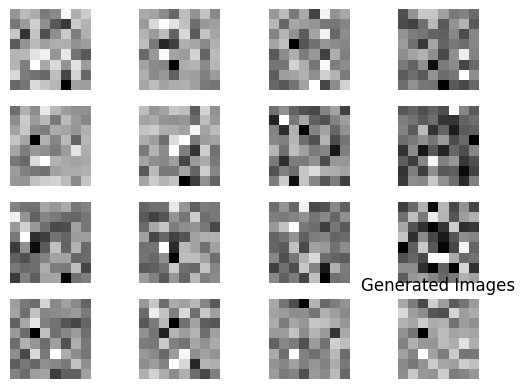

Epoch: 2, val nll=246.20618443080357
saved!


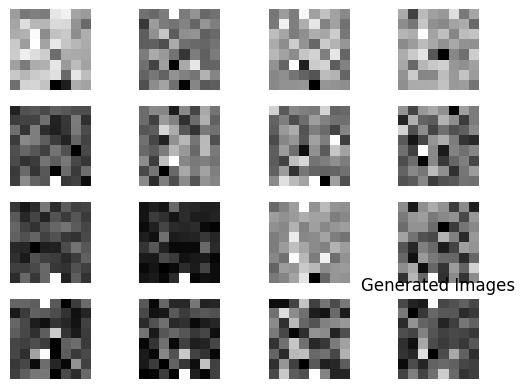

Epoch: 3, val nll=230.57587611607144
saved!


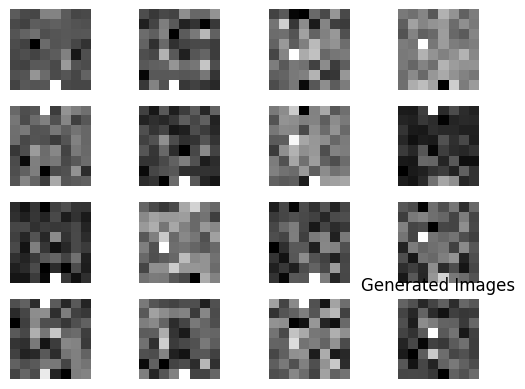

Epoch: 4, val nll=217.95537527901786
saved!


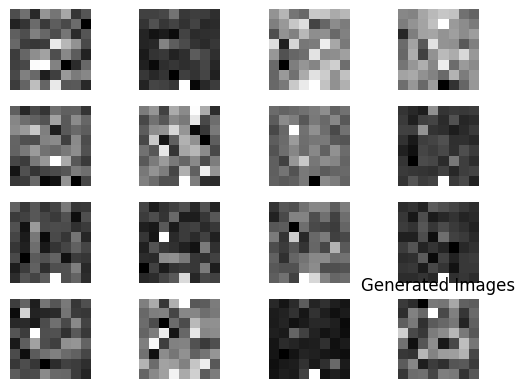

Epoch: 5, val nll=208.03932477678572
saved!


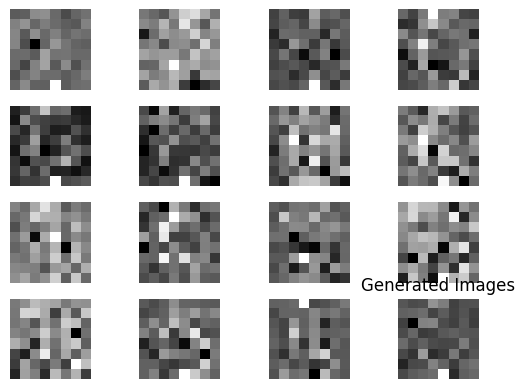

Epoch: 6, val nll=200.17601143973215
saved!


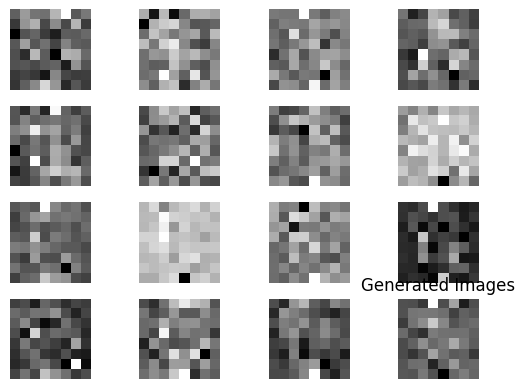

Epoch: 7, val nll=194.00759486607143
saved!


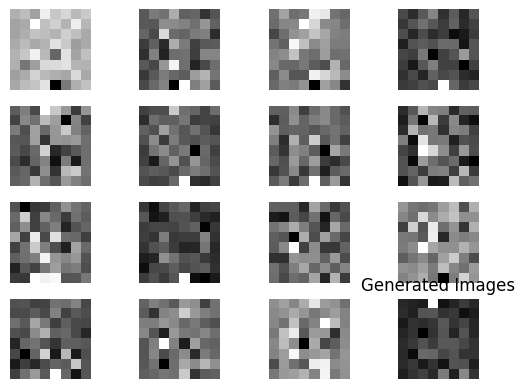

Epoch: 8, val nll=189.2016517857143
saved!


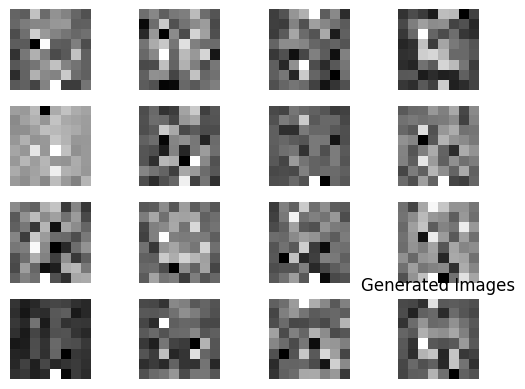

Epoch: 9, val nll=185.48856724330358
saved!


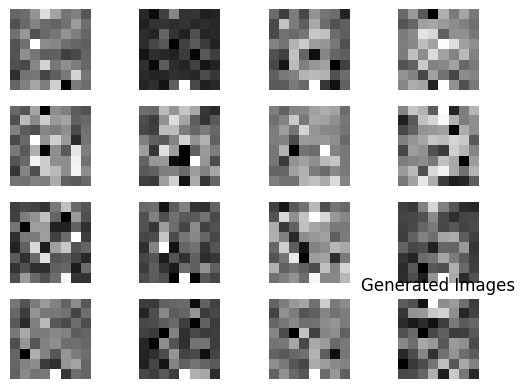

Epoch: 10, val nll=182.40024693080358
saved!


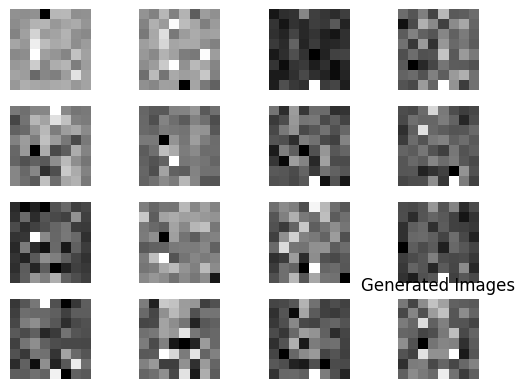

Epoch: 11, val nll=180.04036411830356
saved!


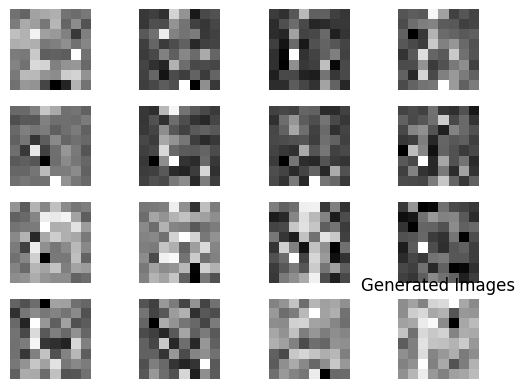

Epoch: 12, val nll=177.49273018973216
saved!


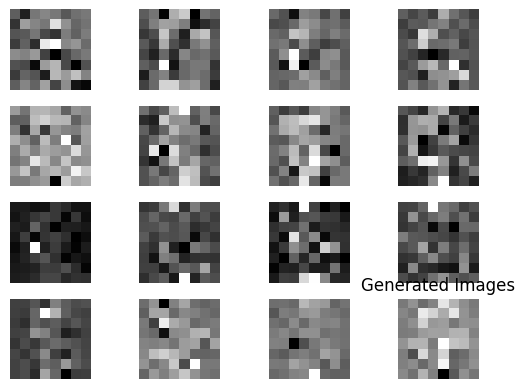

Epoch: 13, val nll=175.5672265625
saved!


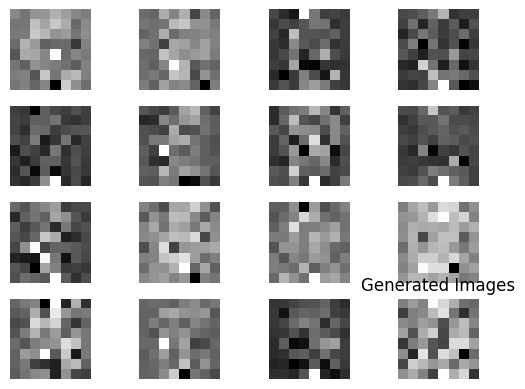

Epoch: 14, val nll=173.637900390625
saved!


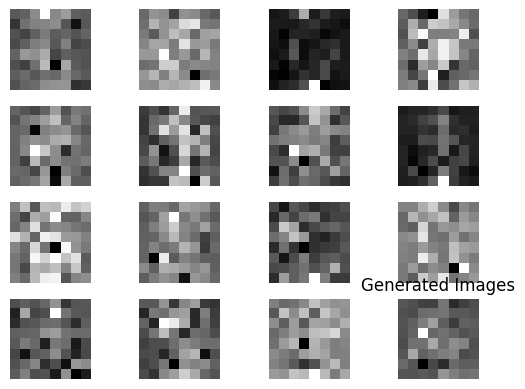

Epoch: 15, val nll=171.93715401785715
saved!


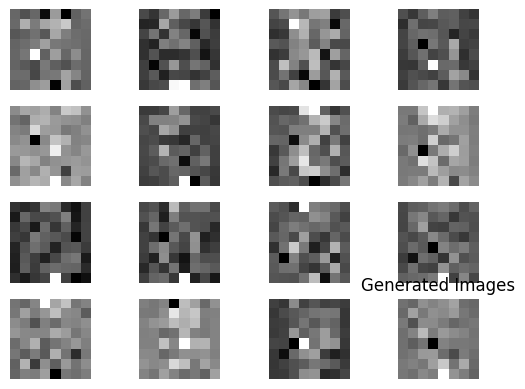

Epoch: 16, val nll=170.34982979910714
saved!


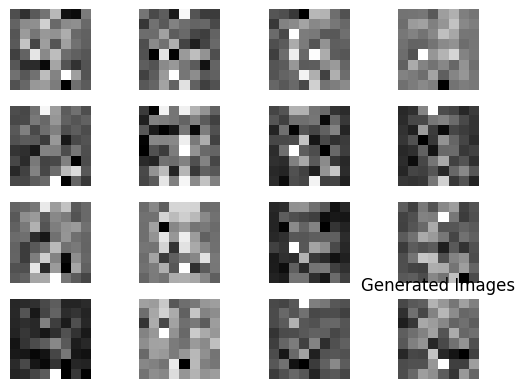

Epoch: 17, val nll=168.9176353236607
saved!


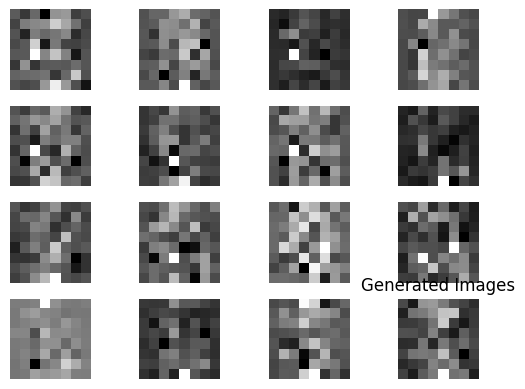

Epoch: 18, val nll=167.81769112723214
saved!


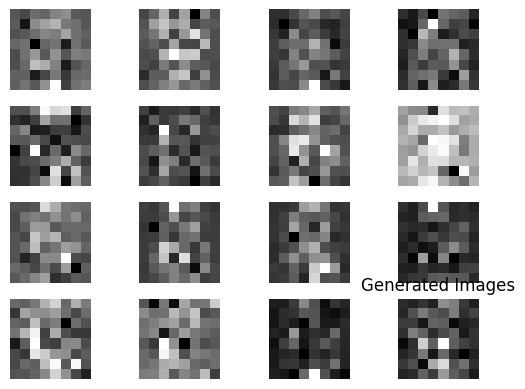

Epoch: 19, val nll=166.4369224330357
saved!


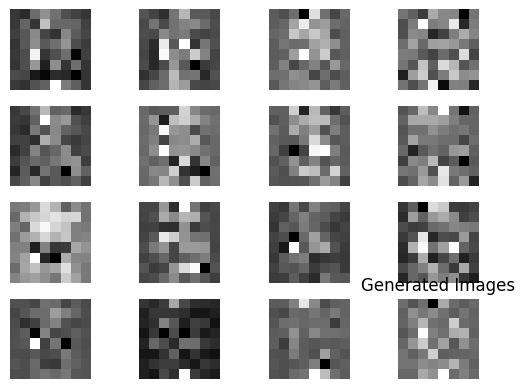

Epoch: 20, val nll=165.21583426339285
saved!


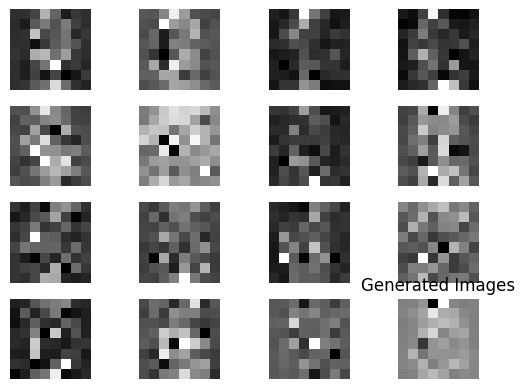

Epoch: 21, val nll=164.53322544642856
saved!


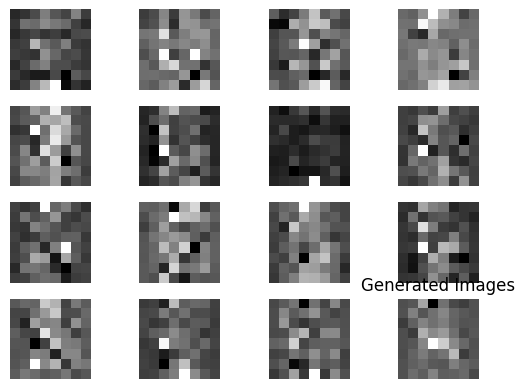

Epoch: 22, val nll=163.54677734375
saved!


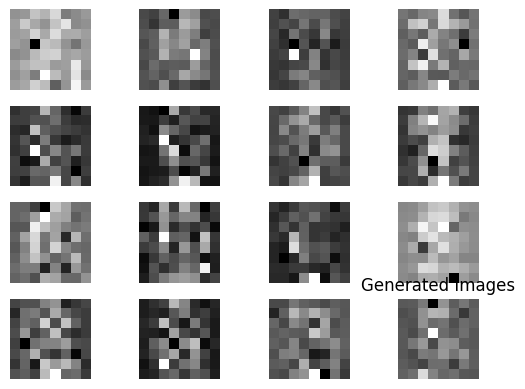

Epoch: 23, val nll=162.74130580357144
saved!


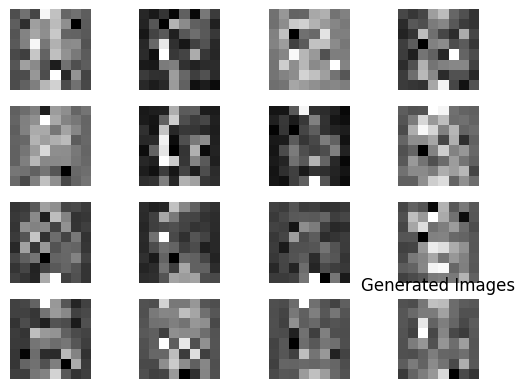

Epoch: 24, val nll=162.07116489955357
saved!


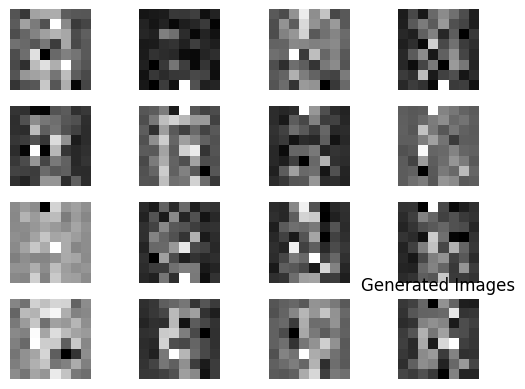

Epoch: 25, val nll=161.44208565848214
saved!


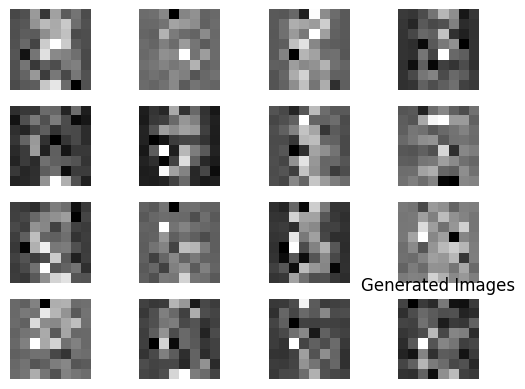

Epoch: 26, val nll=160.59415736607144
saved!


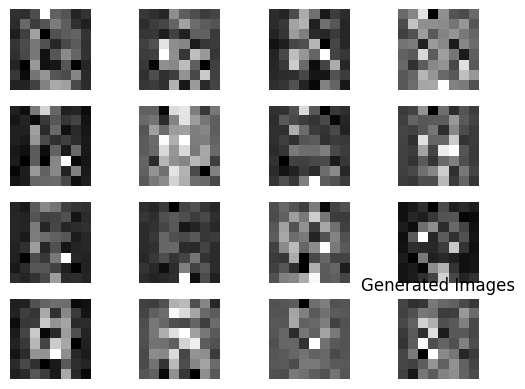

Epoch: 27, val nll=159.92587611607144
saved!


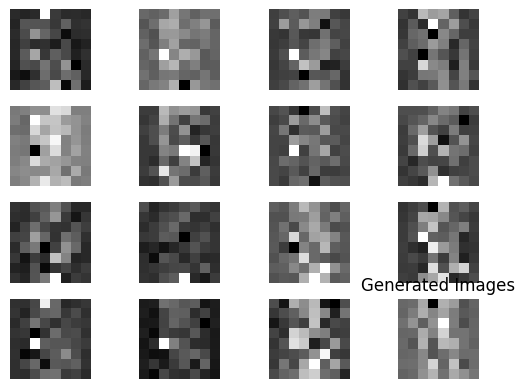

Epoch: 28, val nll=159.6054478236607
saved!


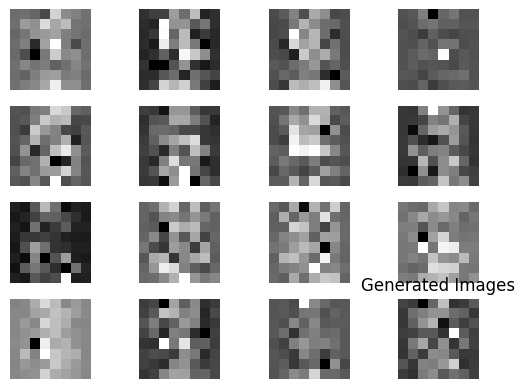

Epoch: 29, val nll=159.04722516741072
saved!


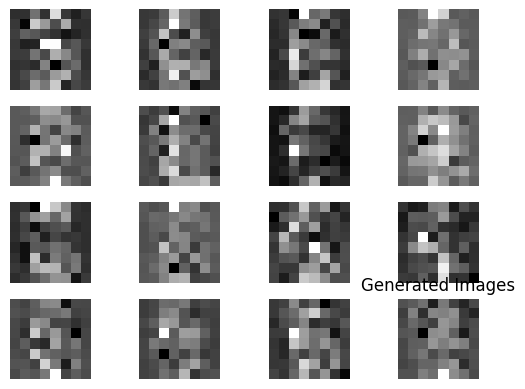

Epoch: 30, val nll=158.39620814732143
saved!


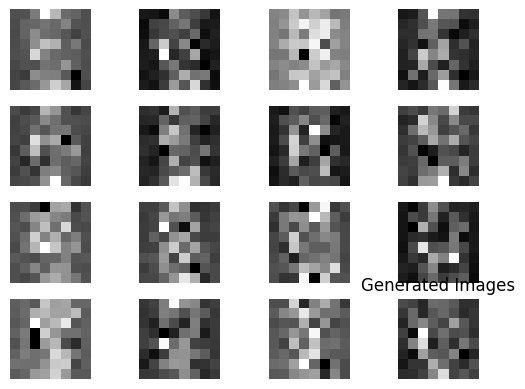

Epoch: 31, val nll=158.0061635044643
saved!


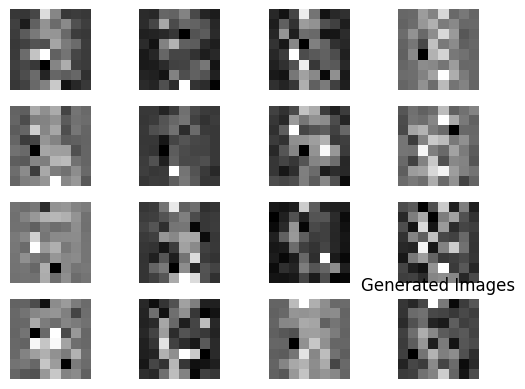

Epoch: 32, val nll=157.81529157366072
saved!


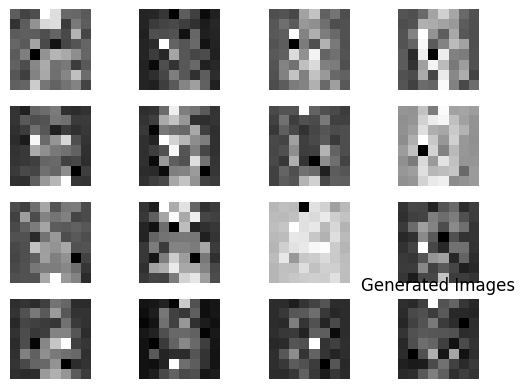

Epoch: 33, val nll=157.43856026785716
saved!


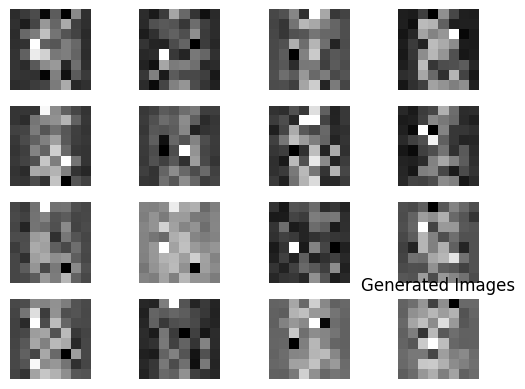

Epoch: 34, val nll=157.05971261160715
saved!


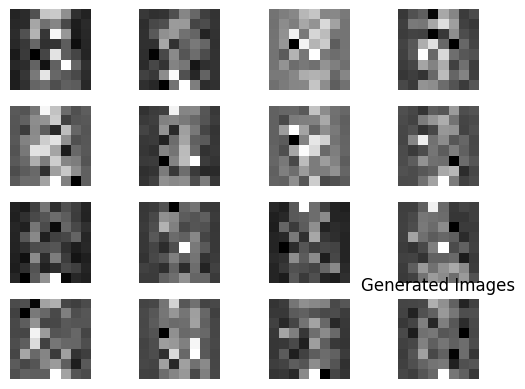

Epoch: 35, val nll=156.3933412388393
saved!


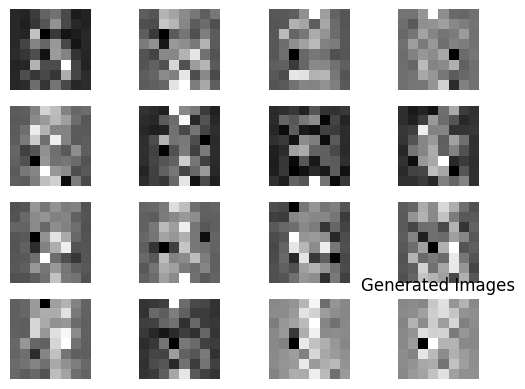

Epoch: 36, val nll=156.16107142857143
saved!


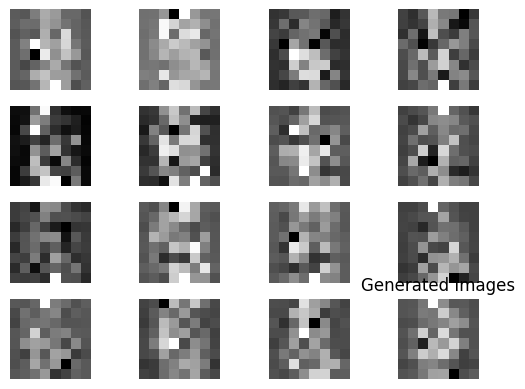

Epoch: 37, val nll=155.97283482142856
saved!


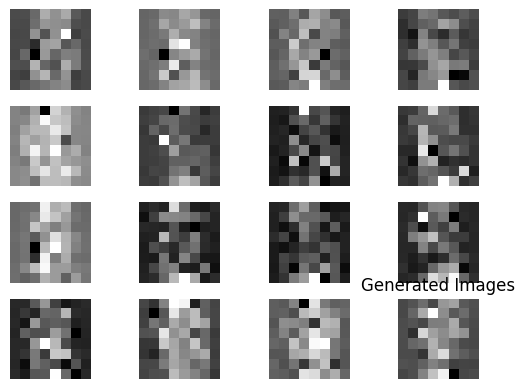

Epoch: 38, val nll=155.38146344866072
saved!


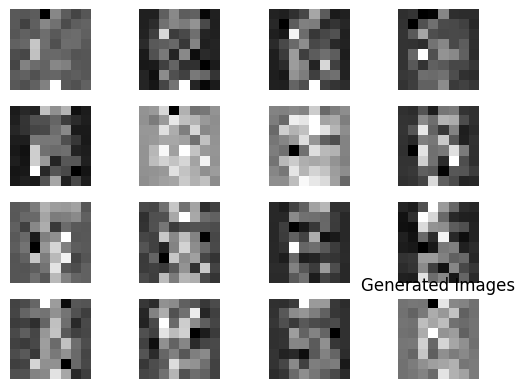

Epoch: 39, val nll=155.06170200892856
saved!


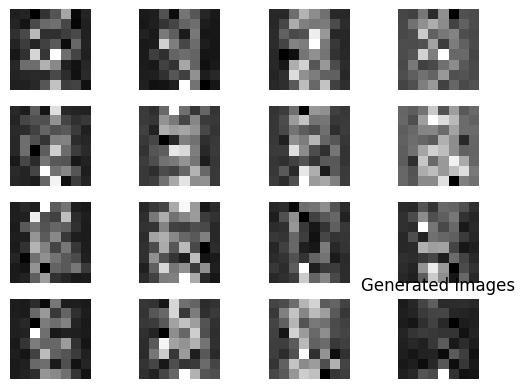

Epoch: 40, val nll=154.68830915178572
saved!


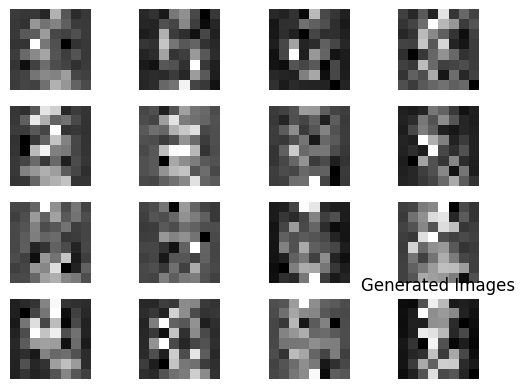

Epoch: 41, val nll=154.45560267857144
saved!


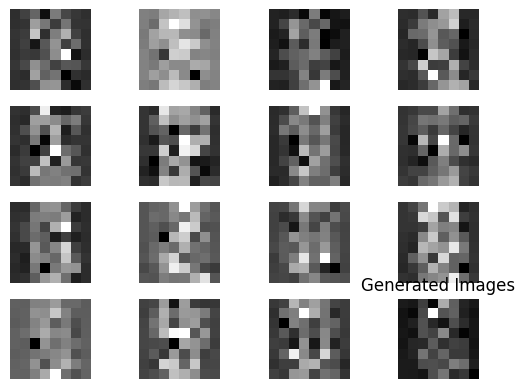

Epoch: 42, val nll=154.18274972098214
saved!


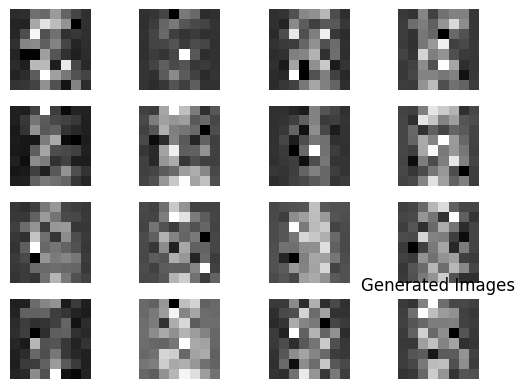

Epoch: 43, val nll=153.94416713169642
saved!


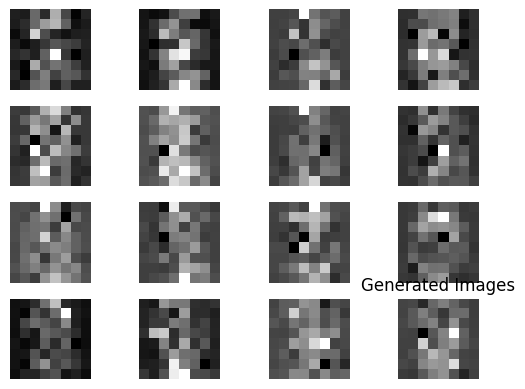

Epoch: 44, val nll=153.82838309151785
saved!


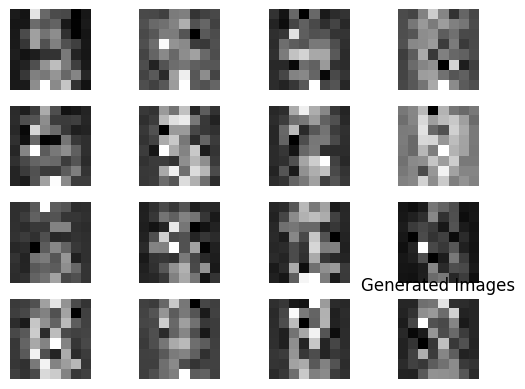

Epoch: 45, val nll=153.29349609375
saved!


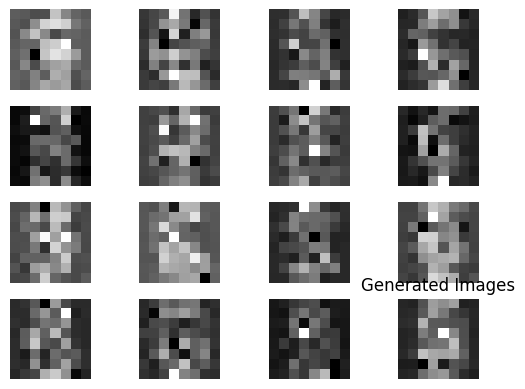

Epoch: 46, val nll=153.17896484375
saved!


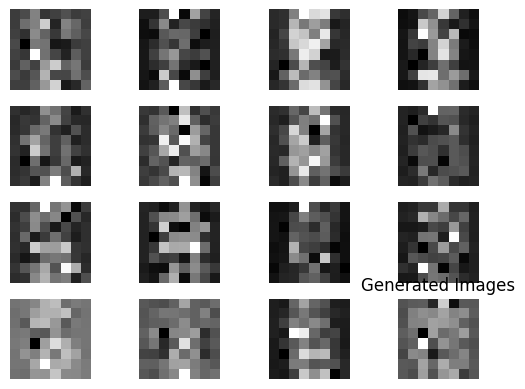

Epoch: 47, val nll=153.30685965401787
Epoch: 48, val nll=152.95311802455356
saved!


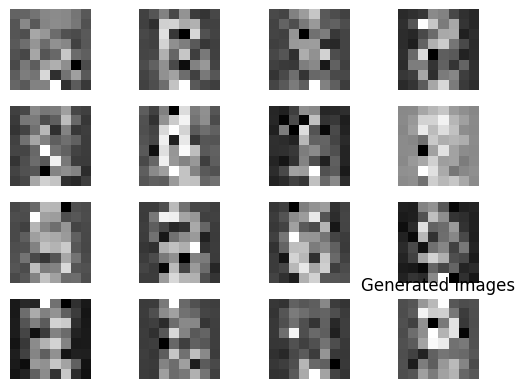

Epoch: 49, val nll=152.67212611607144
saved!


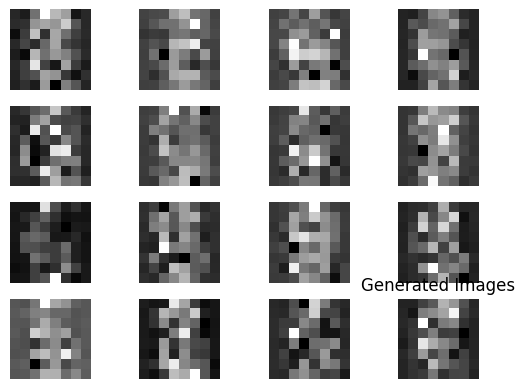

Epoch: 50, val nll=152.38013671875
saved!


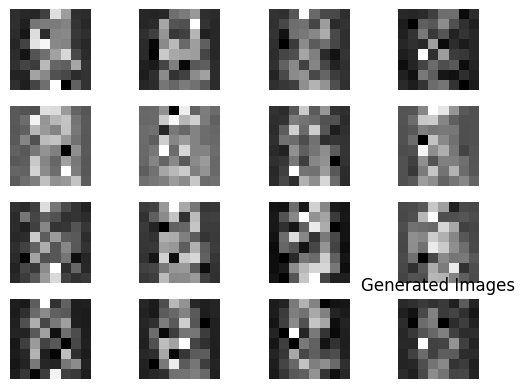

Epoch: 51, val nll=152.22215680803572
saved!


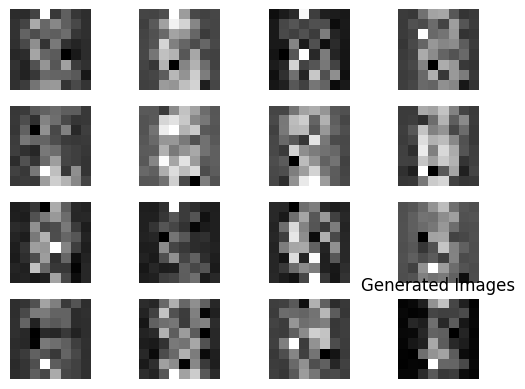

Epoch: 52, val nll=151.4387876674107
saved!


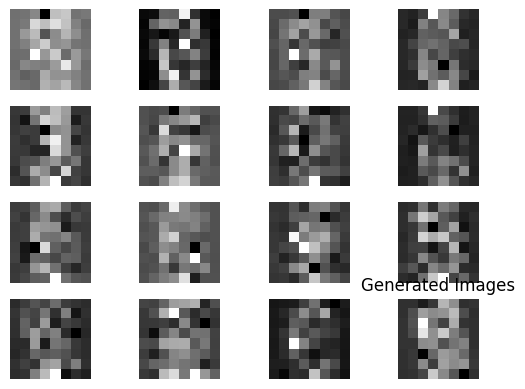

Epoch: 53, val nll=151.65472237723213
Epoch: 54, val nll=151.14226981026786
saved!


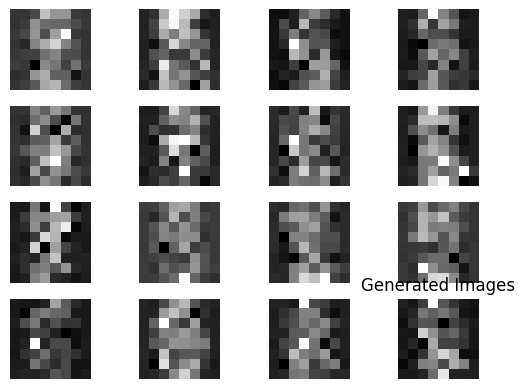

Epoch: 55, val nll=151.74916294642858
Epoch: 56, val nll=151.23709263392857
Epoch: 57, val nll=151.10861607142857
saved!


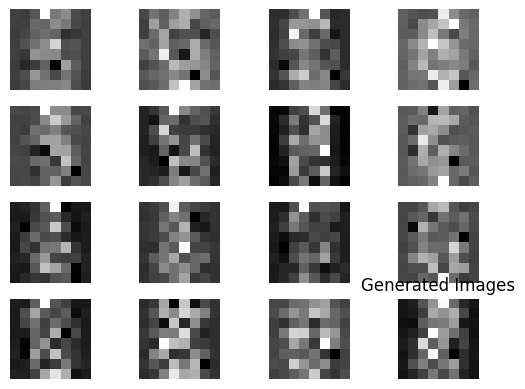

Epoch: 58, val nll=151.09337611607143
saved!


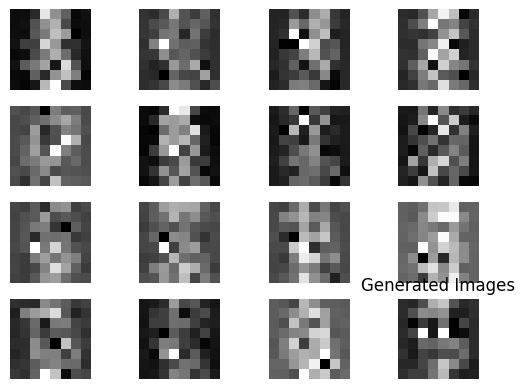

Epoch: 59, val nll=150.15479910714285
saved!


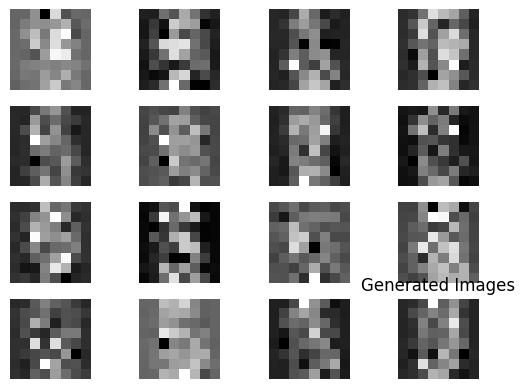

Epoch: 60, val nll=150.4182728794643
Epoch: 61, val nll=150.08302036830358
saved!


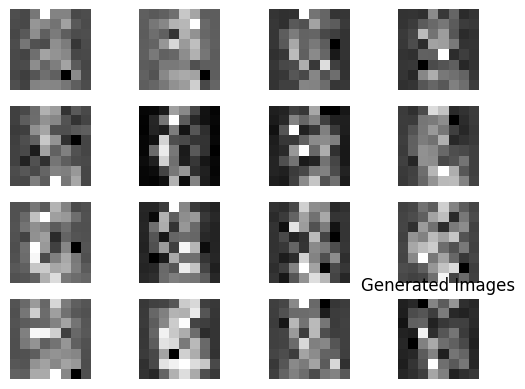

Epoch: 62, val nll=149.7644056919643
saved!


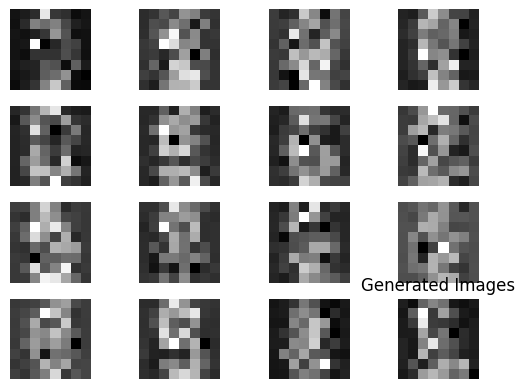

Epoch: 63, val nll=149.37753487723214
saved!


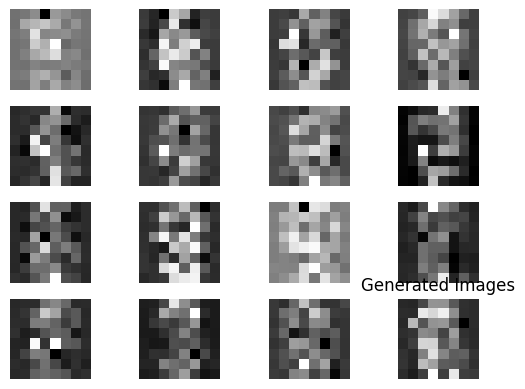

Epoch: 64, val nll=149.26210239955358
saved!


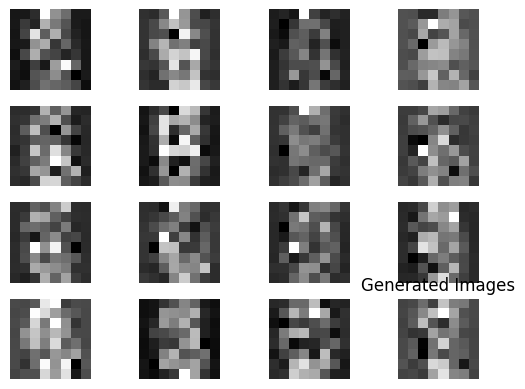

Epoch: 65, val nll=148.196357421875
saved!


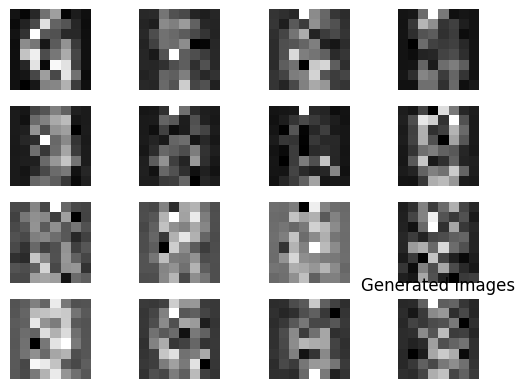

Epoch: 66, val nll=148.81293108258927
Epoch: 67, val nll=147.7743833705357
saved!


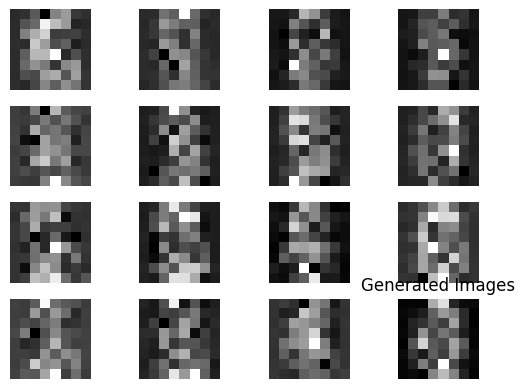

Epoch: 68, val nll=147.90428989955356
Epoch: 69, val nll=148.210771484375
Epoch: 70, val nll=147.5253989955357
saved!


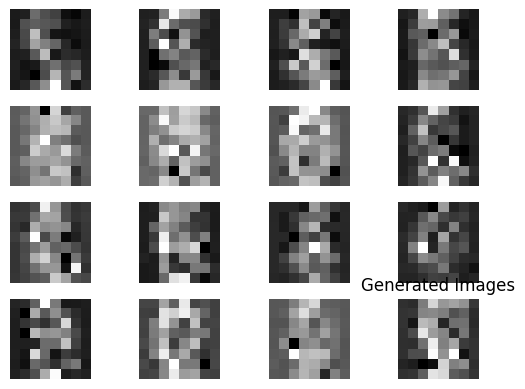

Epoch: 71, val nll=147.4992661830357
saved!


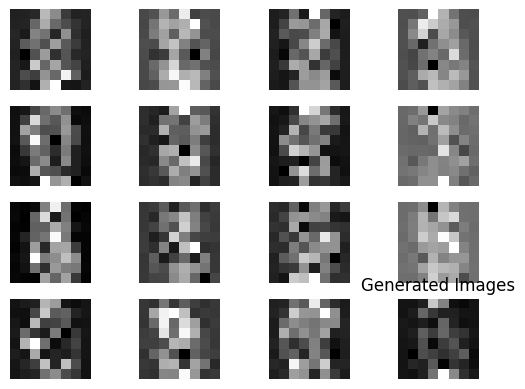

Epoch: 72, val nll=146.8039760044643
saved!


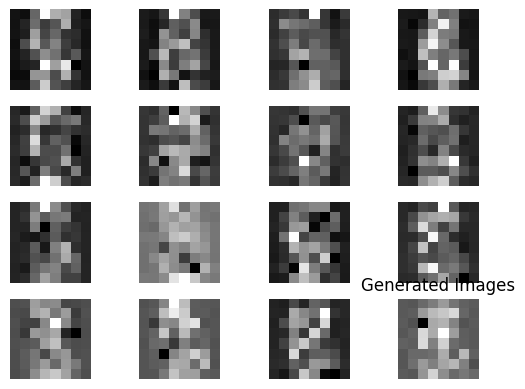

Epoch: 73, val nll=146.77016043526785
saved!


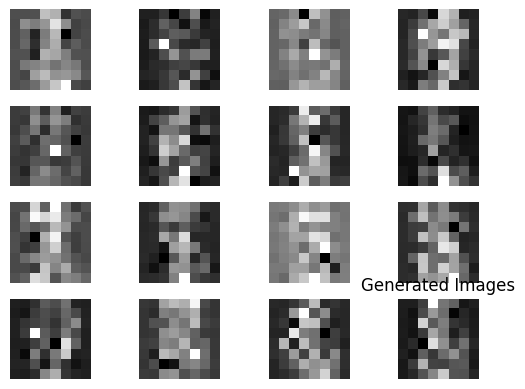

Epoch: 74, val nll=146.55123604910713
saved!


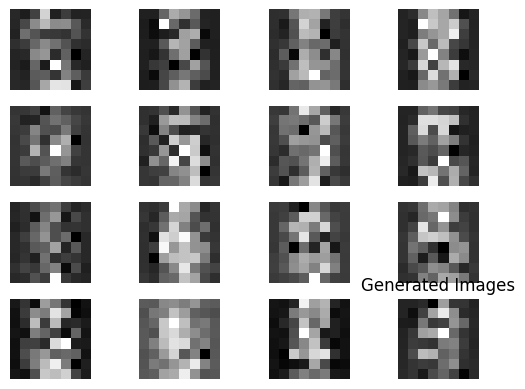

Epoch: 75, val nll=145.73499581473214
saved!


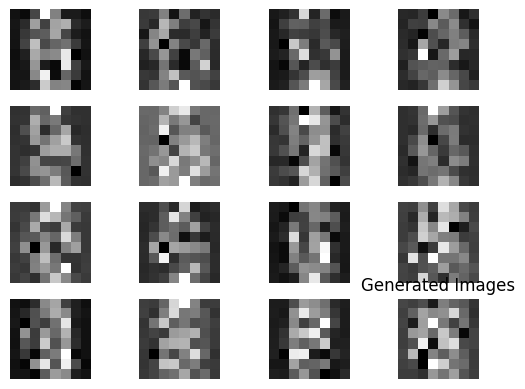

Epoch: 76, val nll=145.51480608258927
saved!


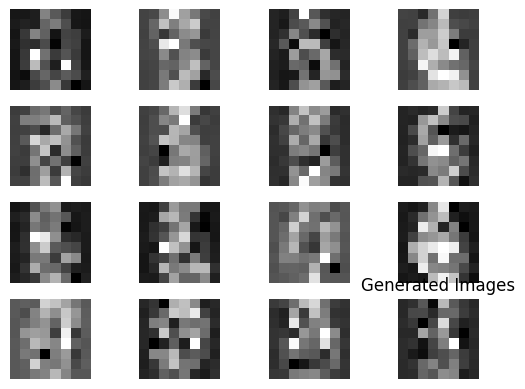

Epoch: 77, val nll=146.042763671875
Epoch: 78, val nll=144.40242606026786
saved!


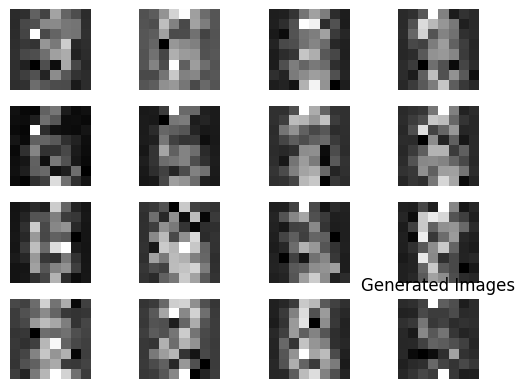

Epoch: 79, val nll=144.43314732142858
Epoch: 80, val nll=144.32743582589285
saved!


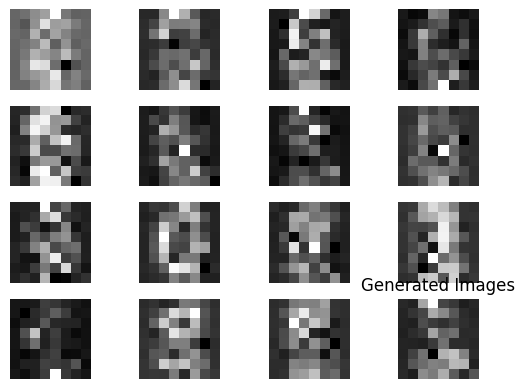

Epoch: 81, val nll=144.63862583705358
Epoch: 82, val nll=143.92898716517857
saved!


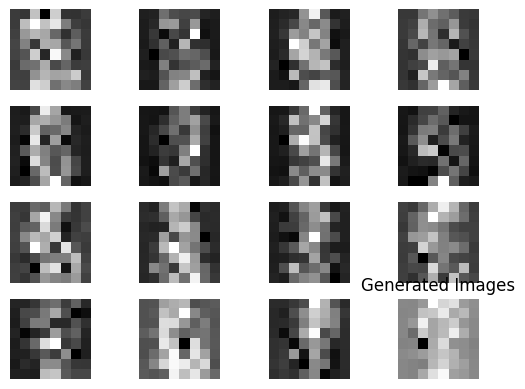

Epoch: 83, val nll=143.8583984375
saved!


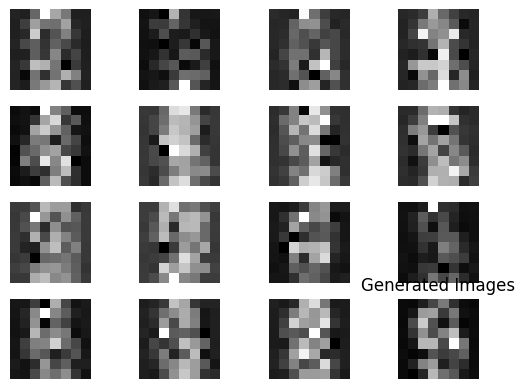

Epoch: 84, val nll=142.60429547991072
saved!


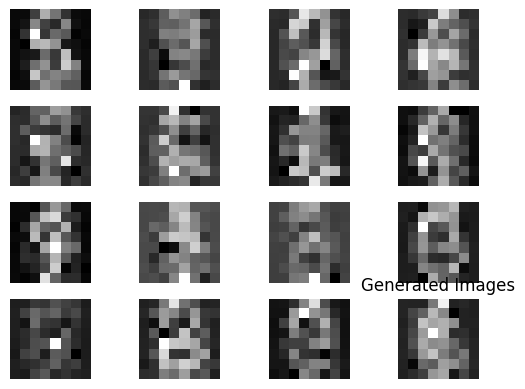

Epoch: 85, val nll=142.58467215401785
saved!


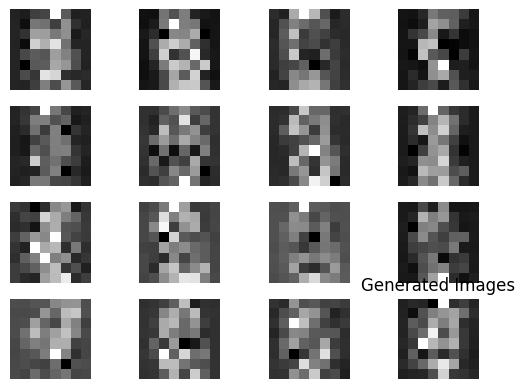

Epoch: 86, val nll=142.41865792410715
saved!


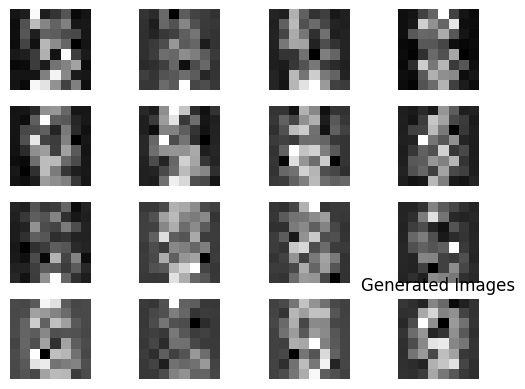

Epoch: 87, val nll=141.67964564732142
saved!


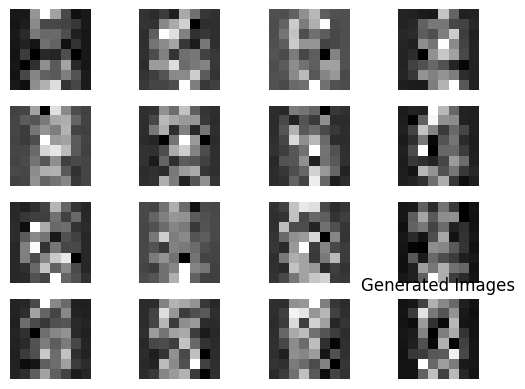

Epoch: 88, val nll=141.14983677455356
saved!


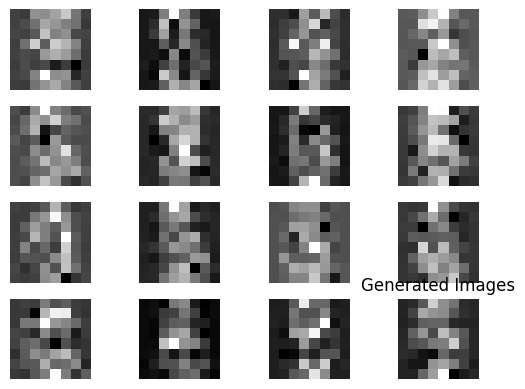

Epoch: 89, val nll=141.54069475446428
Epoch: 90, val nll=140.58224748883927
saved!


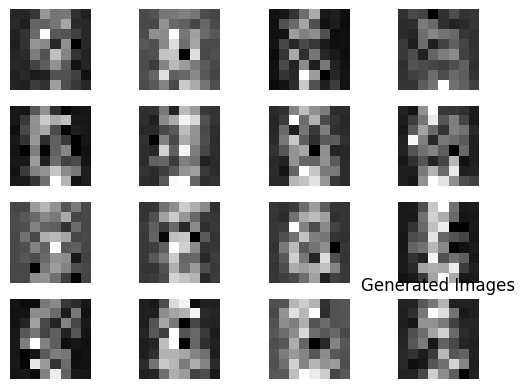

Epoch: 91, val nll=141.4270103236607
Epoch: 92, val nll=140.83955915178572
Epoch: 93, val nll=140.25708426339287
saved!


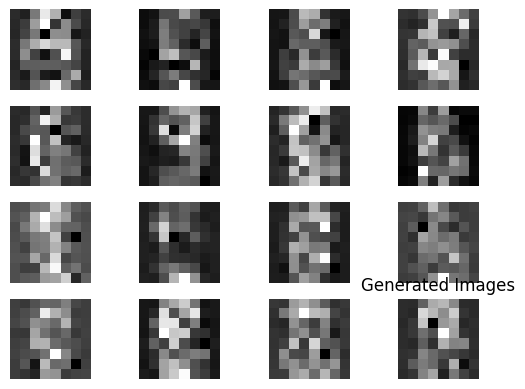

Epoch: 94, val nll=140.54778041294642
Epoch: 95, val nll=139.32277064732142
saved!


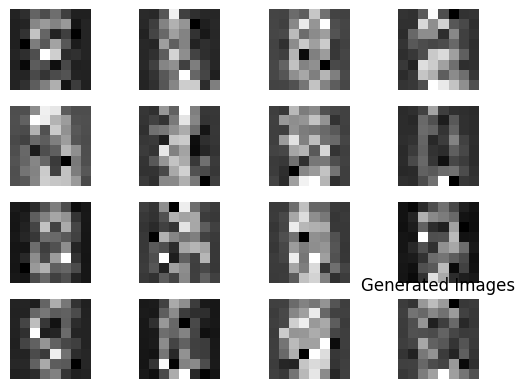

Epoch: 96, val nll=139.73241071428572
Epoch: 97, val nll=140.21554966517857
Epoch: 98, val nll=140.23789341517858
Epoch: 99, val nll=139.20359514508928
saved!


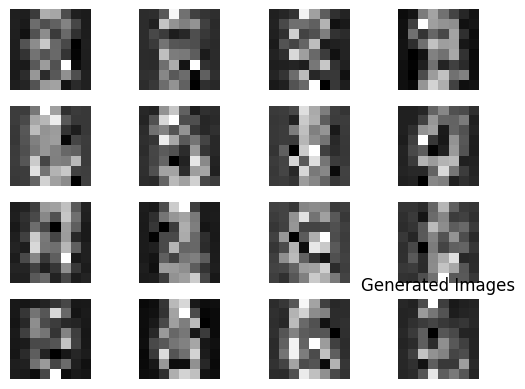

Epoch: 100, val nll=138.55361886160713
saved!


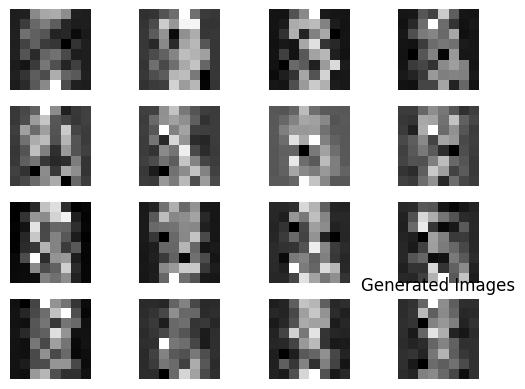

Epoch: 101, val nll=138.22222516741073
saved!


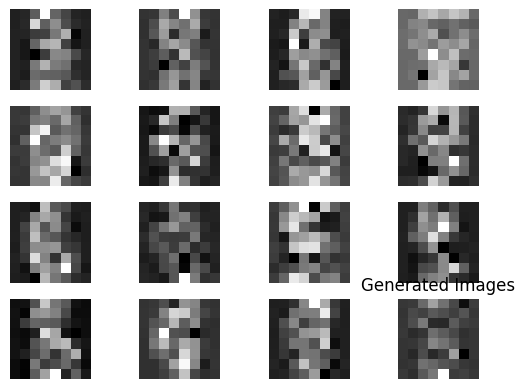

Epoch: 102, val nll=139.10439174107142
Epoch: 103, val nll=138.82158621651786
Epoch: 104, val nll=138.627744140625
Epoch: 105, val nll=137.44749441964285
saved!


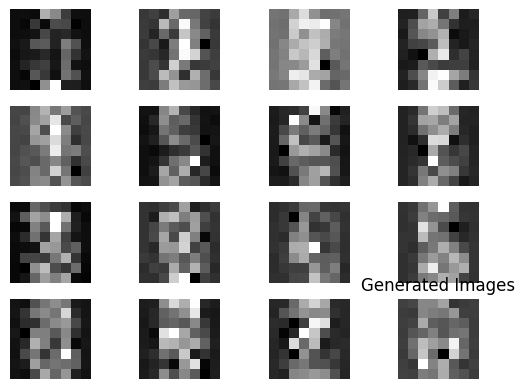

Epoch: 106, val nll=136.66574916294644
saved!


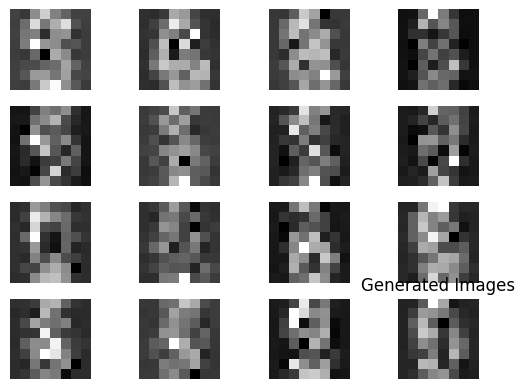

Epoch: 107, val nll=137.13492327008927
Epoch: 108, val nll=137.11683733258928
Epoch: 109, val nll=136.84362025669643
Epoch: 110, val nll=136.44790736607143
saved!


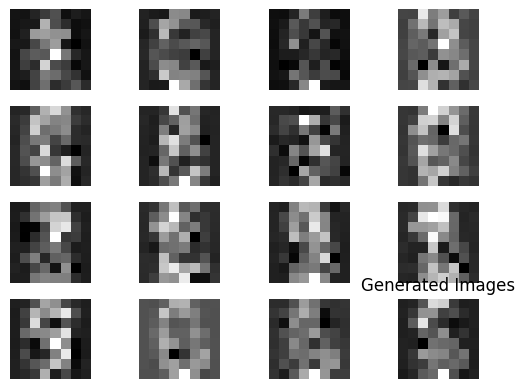

Epoch: 111, val nll=136.51225446428572
Epoch: 112, val nll=136.80336077008928
Epoch: 113, val nll=137.54060267857142
Epoch: 114, val nll=137.5094712611607
Epoch: 115, val nll=136.29468470982144
saved!


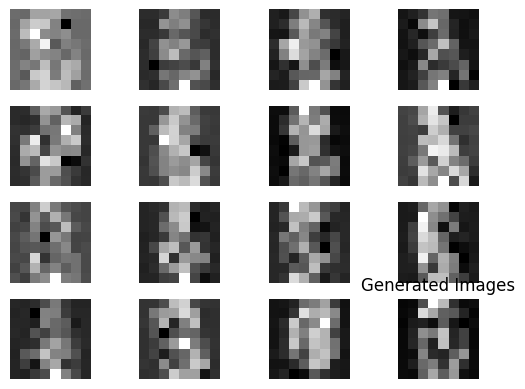

Epoch: 116, val nll=135.809638671875
saved!


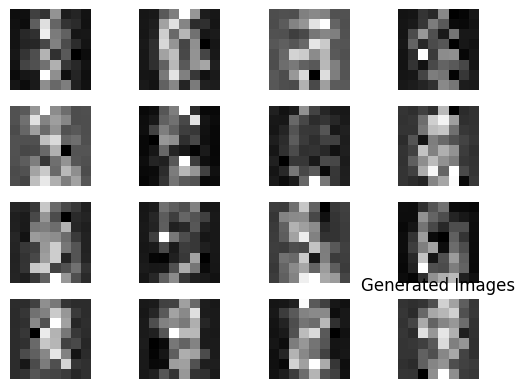

Epoch: 117, val nll=136.40877511160716
Epoch: 118, val nll=135.6167661830357
saved!


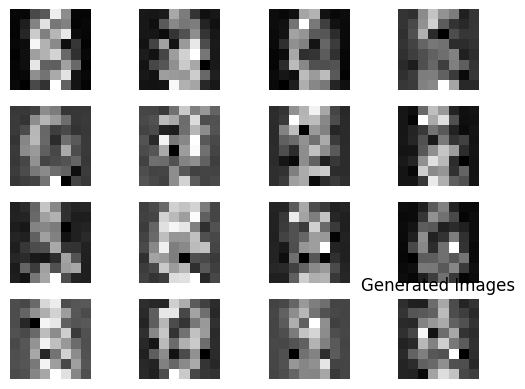

Epoch: 119, val nll=134.99766043526785
saved!


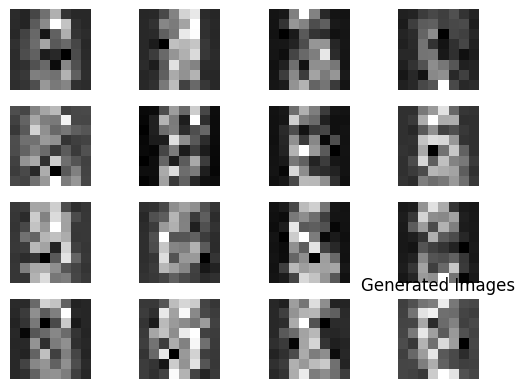

Epoch: 120, val nll=135.53653041294643
Epoch: 121, val nll=136.76105189732144
Epoch: 122, val nll=136.14552315848215
Epoch: 123, val nll=135.944921875
Epoch: 124, val nll=135.64733677455357
Epoch: 125, val nll=134.10634626116072
saved!


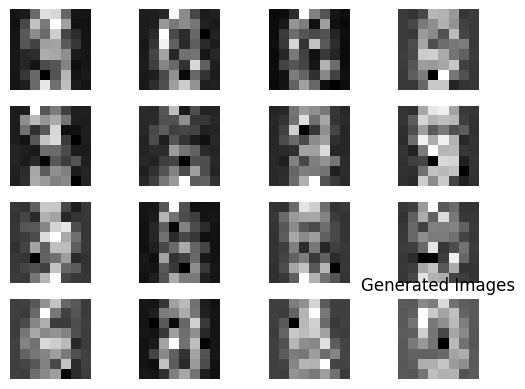

Epoch: 126, val nll=134.03251953125
saved!


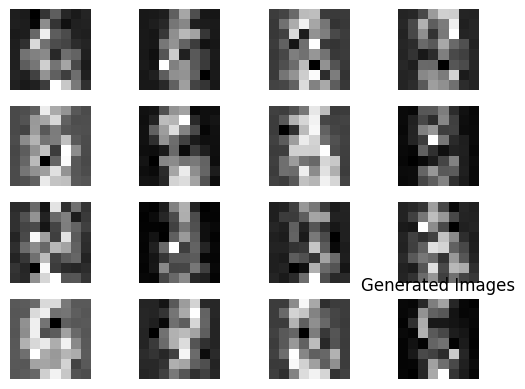

Epoch: 127, val nll=134.93760602678572
Epoch: 128, val nll=134.45082170758928
Epoch: 129, val nll=134.87039341517857
Epoch: 130, val nll=134.03127511160713
saved!


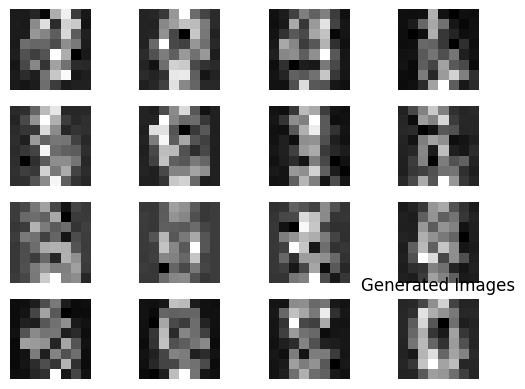

Epoch: 131, val nll=134.3875013950893
Epoch: 132, val nll=132.7683189174107
saved!


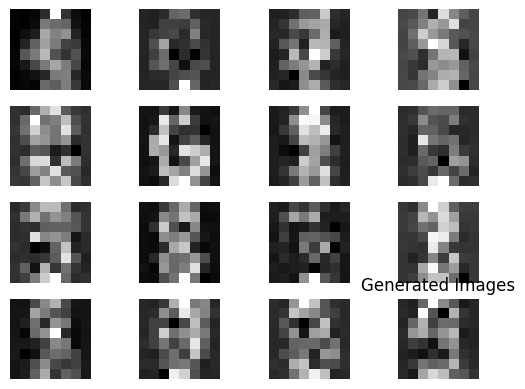

Epoch: 133, val nll=135.00446847098215
Epoch: 134, val nll=134.08656389508928
Epoch: 135, val nll=134.6308803013393
Epoch: 136, val nll=135.25580357142857
Epoch: 137, val nll=134.639140625
Epoch: 138, val nll=133.0483900669643
Epoch: 139, val nll=132.80026088169643
Epoch: 140, val nll=131.68075474330357
saved!


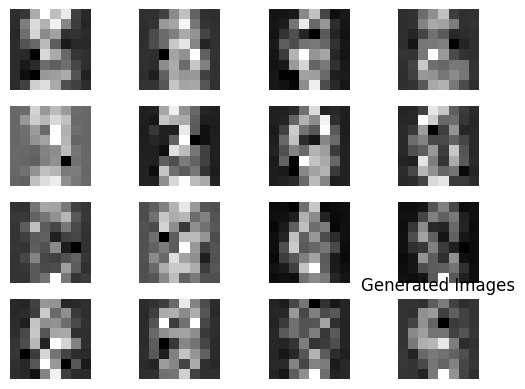

Epoch: 141, val nll=133.09095842633928
Epoch: 142, val nll=134.19691266741071
Epoch: 143, val nll=133.89123046875
Epoch: 144, val nll=131.9132338169643
Epoch: 145, val nll=132.82114397321428
Epoch: 146, val nll=132.07392159598214
Epoch: 147, val nll=131.57378208705356
saved!


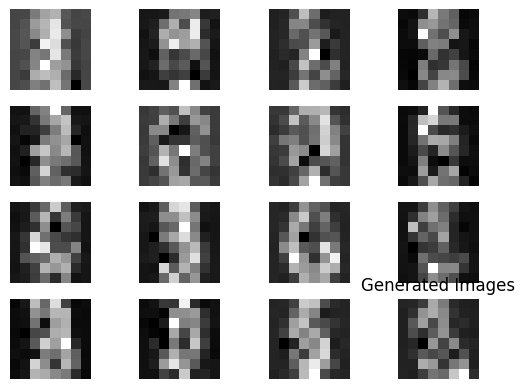

Epoch: 148, val nll=133.06938337053572
Epoch: 149, val nll=131.45764787946428
saved!


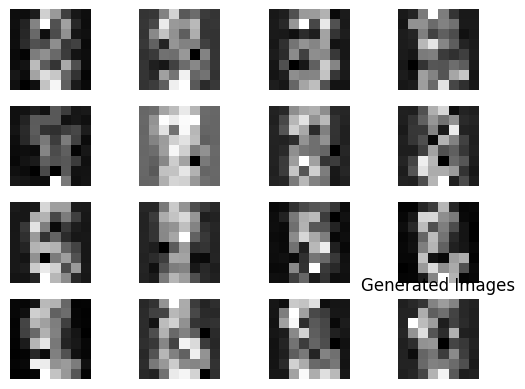

Epoch: 150, val nll=131.83012276785715
Epoch: 151, val nll=132.22028738839285
Epoch: 152, val nll=134.12562081473214
Epoch: 153, val nll=131.17671735491072
saved!


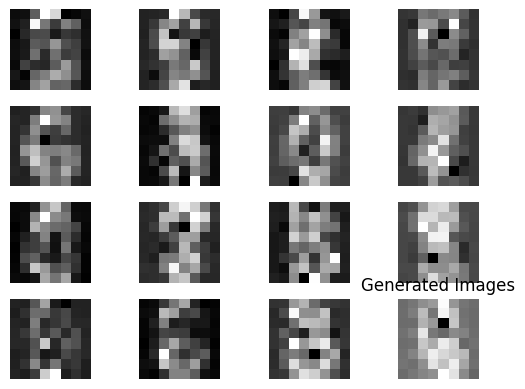

Epoch: 154, val nll=133.63389787946429
Epoch: 155, val nll=131.80184291294643
Epoch: 156, val nll=131.62922712053572
Epoch: 157, val nll=131.12055943080358
saved!


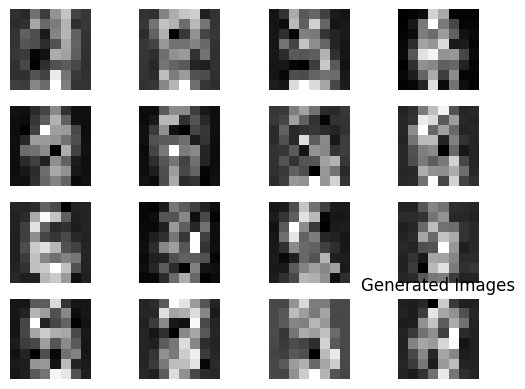

Epoch: 158, val nll=130.45974051339286
saved!


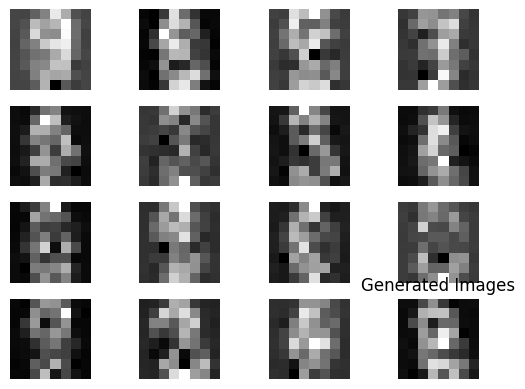

Epoch: 159, val nll=132.70934151785715
Epoch: 160, val nll=132.73496372767858
Epoch: 161, val nll=131.27176199776787
Epoch: 162, val nll=133.25014229910715
Epoch: 163, val nll=135.62807896205356
Epoch: 164, val nll=135.01400809151787
Epoch: 165, val nll=134.16287527901787
Epoch: 166, val nll=130.75859793526786
Epoch: 167, val nll=132.44755440848215
Epoch: 168, val nll=132.2590834263393
Epoch: 169, val nll=130.60368582589285
Epoch: 170, val nll=132.14924246651785
Epoch: 171, val nll=132.06124581473213
Epoch: 172, val nll=129.52761300223213
saved!


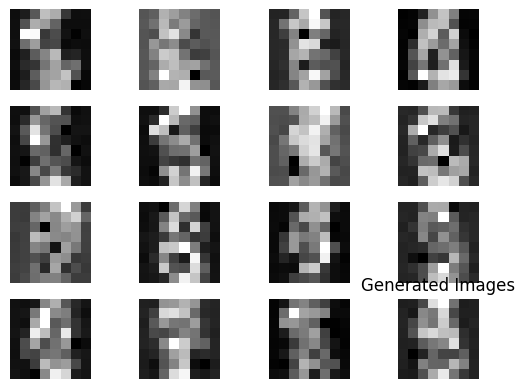

Epoch: 173, val nll=133.08824637276786
Epoch: 174, val nll=134.29494977678573
Epoch: 175, val nll=136.310654296875
Epoch: 176, val nll=132.79738141741072
Epoch: 177, val nll=132.06843470982142
Epoch: 178, val nll=131.7137486049107
Epoch: 179, val nll=136.84498465401785
Epoch: 180, val nll=134.86109375
Epoch: 181, val nll=132.5459765625
Epoch: 182, val nll=134.12450055803572
Epoch: 183, val nll=131.4476353236607
Epoch: 184, val nll=134.57016322544644
Epoch: 185, val nll=133.09589146205357
Epoch: 186, val nll=135.2878515625
Epoch: 187, val nll=136.362998046875
Epoch: 188, val nll=132.15478934151787
Epoch: 189, val nll=135.1196498325893
Epoch: 190, val nll=133.01767159598214
Epoch: 191, val nll=137.72843889508928
Epoch: 192, val nll=135.82948381696428
Epoch: 193, val nll=133.61207170758928


In [11]:
# Training procedure
nll_val = training(name=result_dir + name, max_patience=max_patience, num_epochs=num_epochs, model=model, optimizer=optimizer,
                       training_loader=training_loader, val_loader=val_loader)

Final Loss: nll=117.46043174112137


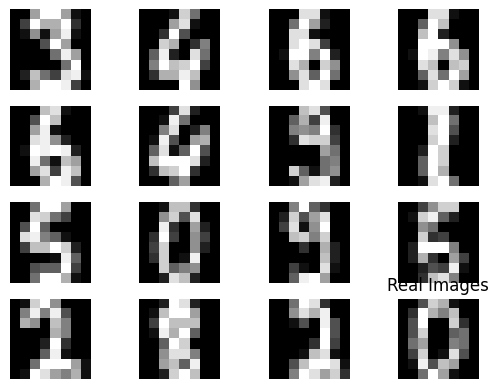

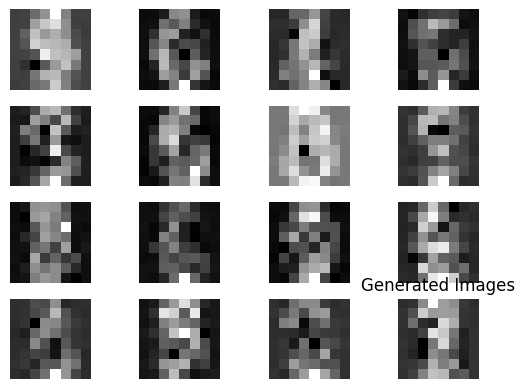

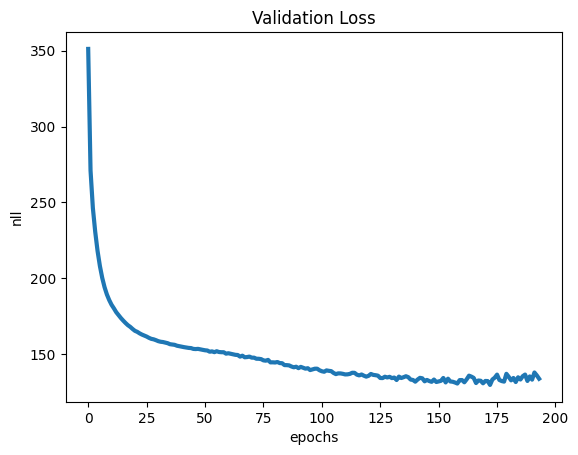

In [12]:
test_loss = evaluation(name=result_dir + name, test_loader=test_loader)
f = open(result_dir + name + '_test_loss.txt', "w")
f.write(str(test_loss))
f.close()

samples_real(result_dir + name, test_loader)

samples_generated(result_dir + name, test_loader)

plot_curve(result_dir + name, nll_val)

## **Integer Discrete Flow**

IDF extends flow-based models to **discrete integer data**. Please read the paper and answer below questions.

### **Questions  **

**Basics:**

- **Q3:** Write down the change-of-variable formula for both RealNVP and IDF.
- **Q4:** Compare the forward and inverse transformations of IDF to RealNVP.
- **Q5:** What role does the scaling function s(x) play in RealNVP? Why must it be removed in IDF?
- **Q6:** Why do we need a discrete prior for integer data?
- **Q7:** How does the `RoundStraightThrough` class allow gradients to flow through integer rounding?
- **Q8:** Research the effect of the rounding step in IDF on training.  

**(Bonus) Experiment:**

- Add a small random noise (dequantization) to IDF inputs and observe training behavior.  
  **Q9:** Does this move IDF behavior closer to RealNVP?





## **Answers**

---

### **Q3 — Change-of-variable formula**

**RealNVP** (continuous flow):

$$
z = f_\theta(x),
$$

$$
p_X(x) = p_Z(f_\theta(x)) \left|\det \frac{\partial f_\theta(x)}{\partial x^\top}\right|,
$$

and the log-likelihood is

$$
\log p_X(x) = \log p_Z(f_\theta(x)) + \log \left| \det J_f(x) \right|.
$$

Because RealNVP uses affine coupling layers, the Jacobian is triangular and the log-determinant reduces to

$$
\log \left| \det J_f(x) \right| = \sum s(\cdot).
$$


**IDF** (discrete flow):

For integer-valued flows acting on the lattice $( \mathbb{Z}^D)$, the transformation is a bijection:

$$
f : \mathbb{Z}^D \to \mathbb{Z}^D.
$$

Thus the discrete change-of-variable formula is simply:

$$
p_X(x) = p_Z(f(x)),
$$

and therefore

$$
\log p_X(x) = \log p_Z(f(x)).
$$

There is **no Jacobian determinant term** in IDF because we are transforming probability **mass**, not density.


---

### **Q4 — Comparing forward/inverse transforms in RealNVP vs IDF**

**RealNVP forward pass** (data → latent):

$$
y_a = x_a,
\qquad
y_b = (x_b - t(x_a)) \odot e^{-s(x_a)}.
$$

**RealNVP inverse pass** (latent → data):

$$
x_a = y_a,
\qquad
x_b = y_b \odot e^{s(y_a)} + t(y_a).
$$


**IDF forward pass** (data → latent, integer additive transform):

For 2-block IDF:

$$
y_a = x_a,
\qquad
y_b = x_b + \mathrm{round}(t(x_a)).
$$

**IDF inverse pass**:

$$
x_a = y_a,
\qquad
x_b = y_b - \mathrm{round}(t(y_a)).
$$

For 4-part IDF, the dependencies cycle through four blocks, but all updates are **integer-additive** and use rounding.

**Main difference:**

- RealNVP uses **continuous affine scaling + translation**.
- IDF uses **integer-preserving additive updates** (no scaling).


---

### **Q5 — Role of \(s(x)\) in RealNVP and why IDF removes it**

In RealNVP:

$$
y_b = x_b \odot e^{s(x_a)} + t(x_a).
$$

The scaling function \(s(x)\):

- Controls **local volume change**.
- Makes RealNVP expressive because the log-determinant is

  $$
  \log|\det J| = \sum s(\cdot).
  $$

In IDF, scaling is removed because:

- Multiplying integers by non-integers leaves the integer lattice.
- Multiplying by integers breaks invertibility unless extra info is stored.
- The Jacobian doesn’t exist in the discrete setting.

Therefore IDF **must** use additive integer transformations only.


---

### **Q6 — Why a discrete prior?**

If $(z\in\mathbb{Z}^D)$, continuous densities (like Gaussians) assign:

$$
P(Z = z) = 0.
$$

We need a **mass function**:

$$
p_Z(z), \qquad z \in \mathbb{Z}^D.
$$

Thus IDF uses a discretized logistic prior, which gives nonzero probability to each integer lattice point.


---

### **Q7 — How `RoundStraightThrough` passes gradients**

True rounding is:

$$
y = \mathrm{round}(x),
\qquad
\frac{\partial y}{\partial x} = 0.
$$

`RoundStraightThrough` uses:

- **Forward pass:**  
  $(y = \mathrm{round}(x))$

- **Backward pass:**  
  Pretends that

  $$
  \frac{\partial y}{\partial x} \approx 1.
  $$

This **identity gradient** lets gradients flow despite discrete operations.


---

### **Q8 — Effect of rounding on IDF training**

Rounding creates:

- A piecewise-constant, non-smooth landscape.
- True gradients are zero almost everywhere.
- Optimization depends entirely on the surrogate (ST) gradient.
- Training becomes noisier and more unstable.
- But we preserve exact **discrete invertibility**.

The model remains a true discrete flow, but the optimization becomes approximate and biased.


---

### **Q9 — Does adding dequantization noise make IDF behave more like RealNVP?**

Adding noise:

$$
\tilde{x} = x + \epsilon, \qquad \epsilon \sim U(-0.5, 0.5)
$$

has these effects:

- The input becomes **continuous**, like RealNVP’s dequantized pixels.
- The loss surface becomes smoother.
- Optimization becomes easier and more stable.
- The model behaves more like a continuous flow.

But for my experiment, I trained three models:

- RealNVP: final test NLL ≈ 117.46  
- IDF (discrete): final test NLL ≈ 142.48  
- IDF with dequantization noise: final test NLL ≈ 143.90  

Thus, adding noise **did not** move IDF “closer” to RealNVP in terms of test NLL; in fact, it slightly hurt performance. Conceptually, dequantization makes the optimization more similar to continuous flows, but it also breaks the clean discrete-flow interpretation and is not guaranteed to improve likelihood on the discrete data.



### **Distributions**

In [13]:
# Chakraborty & Chakravarty, "A new discrete probability distribution with integer support on (−∞, ∞)",
#  Communications in Statistics - Theory and Methods, 45:2, 492-505, DOI: 10.1080/03610926.2013.830743

def log_min_exp(a, b, epsilon=1e-8):
    """
    Source: https://github.com/jornpeters/integer_discrete_flows
    Computes the log of exp(a) - exp(b) in a (more) numerically stable fashion.
    Using:
     log(exp(a) - exp(b))
     c + log(exp(a-c) - exp(b-c))
     a + log(1 - exp(b-a))
    And note that we assume b < a always.
    """
    y = a + torch.log(1 - torch.exp(b - a) + epsilon)

    return y

def log_integer_probability(x, mean, logscale):
    scale = torch.exp(logscale)

    logp = log_min_exp(
        F.logsigmoid((x + 0.5 - mean) / scale),
        F.logsigmoid((x - 0.5 - mean) / scale))

    return logp

In [14]:
class RoundStraightThrough(torch.autograd.Function):

    def __init__(self):
        super().__init__()

    @staticmethod
    def forward(ctx, input):
        rounded = torch.round(input, out=None)
        return rounded

    @staticmethod
    def backward(ctx, grad_output):
        grad_input = grad_output.clone()
        return grad_input

In [15]:
class IDF(nn.Module):
    def __init__(self, netts, num_flows, D=2):
        super(IDF, self).__init__()

        if len(netts) == 1:
            self.t = torch.nn.ModuleList([netts[0]() for _ in range(num_flows)])
            self.idf_git = 1

        elif len(netts) == 4:
            self.t_a = torch.nn.ModuleList([netts[0]() for _ in range(num_flows)])
            self.t_b = torch.nn.ModuleList([netts[1]() for _ in range(num_flows)])
            self.t_c = torch.nn.ModuleList([netts[2]() for _ in range(num_flows)])
            self.t_d = torch.nn.ModuleList([netts[3]() for _ in range(num_flows)])
            self.idf_git = 4

        else:
            raise ValueError('You can provide either 1 or 4 translation nets.')

        self.num_flows = num_flows

        self.round = RoundStraightThrough.apply

        self.mean = nn.Parameter(torch.zeros(1, D))
        self.logscale = nn.Parameter(torch.ones(1, D))

        self.D = D

    def coupling(self, x, index, forward=True):

        if self.idf_git == 1:
            (xa, xb) = torch.chunk(x, 2, 1)

            if forward:
                yb = xb + self.round(self.t[index](xa))
            else:
                yb = xb - self.round(self.t[index](xa))

            return torch.cat((xa, yb), 1)

        elif self.idf_git == 4:
            (xa, xb, xc, xd) = torch.chunk(x, 4, 1)

            if forward:
                ya = xa + self.round(self.t_a[index](torch.cat((xb, xc, xd), 1)))
                yb = xb + self.round(self.t_b[index](torch.cat((ya, xc, xd), 1)))
                yc = xc + self.round(self.t_c[index](torch.cat((ya, yb, xd), 1)))
                yd = xd + self.round(self.t_d[index](torch.cat((ya, yb, yc), 1)))
            else:
                yd = xd - self.round(self.t_d[index](torch.cat((xa, xb, xc), 1)))
                yc = xc - self.round(self.t_c[index](torch.cat((xa, xb, yd), 1)))
                yb = xb - self.round(self.t_b[index](torch.cat((xa, yc, yd), 1)))
                ya = xa - self.round(self.t_a[index](torch.cat((yb, yc, yd), 1)))

            return torch.cat((ya, yb, yc, yd), 1)

    def permute(self, x):
        return x.flip(1)

    def f(self, x):
        z = x
        for i in range(self.num_flows):
            z = self.coupling(z, i, forward=True)
            z = self.permute(z)

        return z

    def f_inv(self, z):
        x = z
        for i in reversed(range(self.num_flows)):
            x = self.permute(x)
            x = self.coupling(x, i, forward=False)

        return x

    def forward(self, x, reduction='avg'):
        z = self.f(x)
        if reduction == 'sum':
            return -self.log_prior(z).sum()
        else:
            return -self.log_prior(z).mean()

    def sample(self, batchSize):
        # Sample z:
        z = self.prior_sample(batchSize=batchSize, D=self.D)
        # x = f^-1(z)
        x = self.f_inv(z)
        return x.view(batchSize, 1, self.D)

    def log_prior(self, x):
        log_p = log_integer_probability(x, self.mean, self.logscale)
        return log_p.sum(1)

    def prior_sample(self, batchSize, D=2):
        # Sample from logistic
        y = torch.rand(batchSize, self.D)
        x = torch.exp(self.logscale) * torch.log(y / (1. - y)) + self.mean
        # And then round it to an integer.
        return torch.round(x)

In [16]:
def evaluation(test_loader, name=None, model_best=None, epoch=None):
    # Evaluation
    if model_best is None:
        # Load the best performing model
        model_best = IDF(netts, num_flows, D=D)

        # Load state_dict into the model
        model_best.load_state_dict(torch.load(name + '.model'))

    model_best.eval()
    loss = 0.
    N = 0.
    for indx_batch, test_batch in enumerate(test_loader):
        loss_t = model_best.forward(test_batch, reduction='sum')
        loss = loss + loss_t.item()
        N = N + test_batch.shape[0]
    loss = loss / N

    if epoch is None:
        print(f'Final Loss: nll={loss}')
    else:
        print(f'Epoch: {epoch}, val nll={loss}')

    return loss


def samples_real(name, test_loader):
    # REAL-------
    num_x = 4
    num_y = 4
    x = next(iter(test_loader)).detach().numpy()

    fig, ax = plt.subplots(num_x, num_y)
    for i, ax in enumerate(ax.flatten()):
        plottable_image = np.reshape(x[i], (8, 8))
        ax.imshow(plottable_image, cmap='gray')
        ax.axis('off')

    plt.savefig(name+'_real_images.pdf', bbox_inches='tight')
    plt.title("Real Images")
    plt.show()
    plt.close()


def samples_generated(name, data_loader, extra_name=''):
    x = next(iter(data_loader)).detach().numpy()

    # GENERATIONS-------
    model_best = IDF(netts, num_flows, D=D)

    # Load state_dict into the model
    model_best.load_state_dict(torch.load(name + '.model'))
    model_best.eval()

    num_x = 4
    num_y = 4
    x = model_best.sample(num_x * num_y)
    x = x.detach().numpy()

    fig, ax = plt.subplots(num_x, num_y)
    for i, ax in enumerate(ax.flatten()):
        plottable_image = np.reshape(x[i], (8, 8))
        ax.imshow(plottable_image, cmap='gray')
        ax.axis('off')

    plt.savefig(name + '_generated_images' + extra_name + '.pdf', bbox_inches='tight')
    plt.title("Generated Images")
    plt.show()
    plt.close()


def plot_curve(name, nll_val):
    plt.plot(np.arange(len(nll_val)), nll_val, linewidth='3')
    plt.xlabel('epochs')
    plt.ylabel('nll')
    plt.savefig(name + '_nll_val_curve.pdf', bbox_inches='tight')
    plt.title("Validation Loss")
    plt.show()
    plt.close()

In [17]:
def training(name, max_patience, num_epochs, model, optimizer, training_loader, val_loader):
    nll_val = []
    best_nll = 1000.
    patience = 0

    # Main loop
    for e in range(num_epochs):
        # Training
        model.train()
        for indx_batch, batch in enumerate(training_loader):

            loss = model.forward(batch)

            optimizer.zero_grad()
            loss.backward(retain_graph=True)
            optimizer.step()

        # Validation
        loss_val = evaluation(val_loader, model_best=model, epoch=e)
        nll_val.append(loss_val)  # Save for plotting

        if e == 0:
            print('saved!')
            torch.save(model.state_dict(), name + '.model')
            best_nll = loss_val
        else:
            if loss_val < best_nll:
                print('saved!')
                torch.save(model.state_dict(), name + '.model')
                best_nll = loss_val
                patience = 0

                samples_generated(name, val_loader, extra_name="_epoch_" + str(e))
            else:
                patience = patience + 1

        if patience > max_patience:
            break

    nll_val = np.asarray(nll_val)

    return nll_val

### **Initialize Dataloaders**

In [18]:
train_data = Digits(mode='train')
val_data = Digits(mode='val')
test_data = Digits(mode='test')

training_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

result_dir = 'results/'
if not(os.path.exists(result_dir)):
    os.mkdir(result_dir)
name = 'idf'

### **Hyperparams**

In [19]:
D = 64                  # Input dimension
M = 256                 # The number of neurons in scale (s) and translation (t) nets

lr = 1e-3               # Learning rate
num_epochs = 1000       # Max. number of epochs
max_patience = 20       # An early stopping is used, if training doesn't improve for longer than 20 epochs, it is stopped

### **Initialize IDF**

In [20]:
# The number of invertible transformations
num_flows = 8

# This variable defines whether we use:
#   1 - the classic coupling layer proposed in (Hogeboom et al., 2019)
#   4 - the general invertible transformation in (Tomczak, 2020) with 4 partitions
idf_git = 4

if idf_git == 1:
    nett = lambda: nn.Sequential(nn.Linear(D // 2, M), nn.LeakyReLU(),
                                     nn.Linear(M, M), nn.LeakyReLU(),
                                     nn.Linear(M, D // 2))
    netts = [nett]

elif idf_git == 4:
    nett_a = lambda: nn.Sequential(nn.Linear(3 * (D // 4), M), nn.LeakyReLU(),
                                       nn.Linear(M, M), nn.LeakyReLU(),
                                       nn.Linear(M, D // 4))

    nett_b = lambda: nn.Sequential(nn.Linear(3 * (D // 4), M), nn.LeakyReLU(),
                                       nn.Linear(M, M), nn.LeakyReLU(),
                                       nn.Linear(M, D // 4))

    nett_c = lambda: nn.Sequential(nn.Linear(3 * (D // 4), M), nn.LeakyReLU(),
                                       nn.Linear(M, M), nn.LeakyReLU(),
                                       nn.Linear(M, D // 4))

    nett_d = lambda: nn.Sequential(nn.Linear(3 * (D // 4), M), nn.LeakyReLU(),
                                       nn.Linear(M, M), nn.LeakyReLU(),
                                       nn.Linear(M, D // 4))

    netts = [nett_a, nett_b, nett_c, nett_d]

# Init IDF
model = IDF(netts, num_flows, D=D)

In [21]:
# Optimizer
optimizer = torch.optim.Adamax([p for p in model.parameters() if p.requires_grad == True], lr=lr)

Epoch: 0, val nll=178.7506361607143
saved!
Epoch: 1, val nll=174.76718331473214
saved!


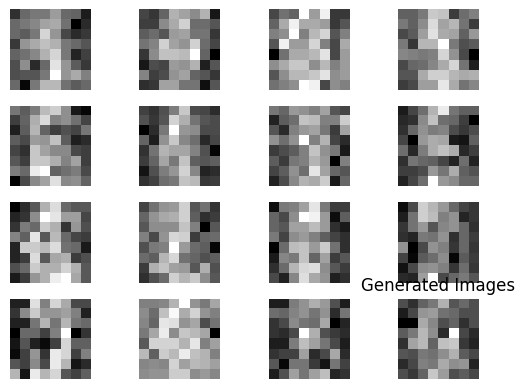

Epoch: 2, val nll=172.5034095982143
saved!


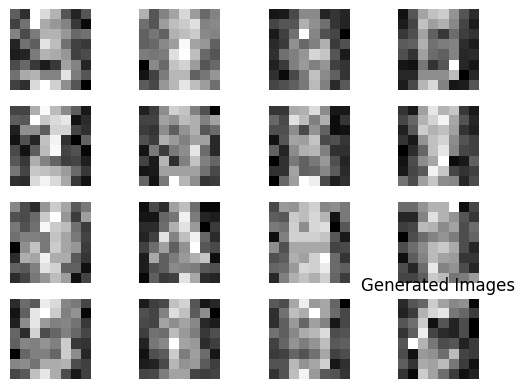

Epoch: 3, val nll=170.61307198660714
saved!


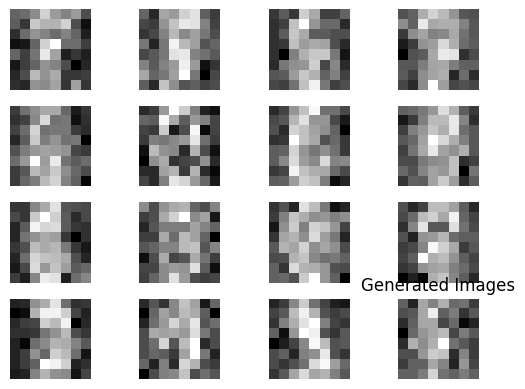

Epoch: 4, val nll=169.09667410714286
saved!


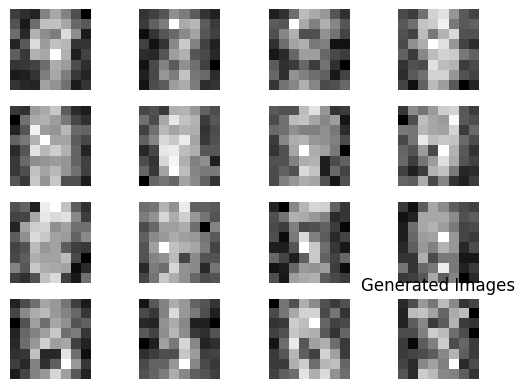

Epoch: 5, val nll=167.74200613839287
saved!


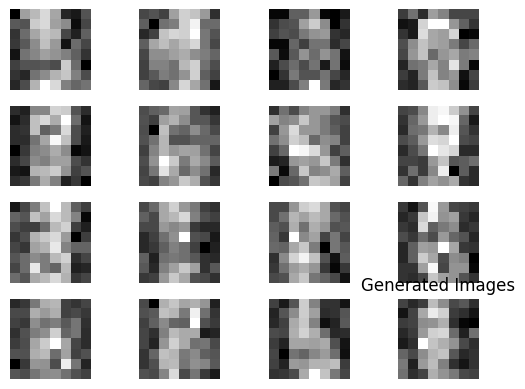

Epoch: 6, val nll=166.53155552455357
saved!


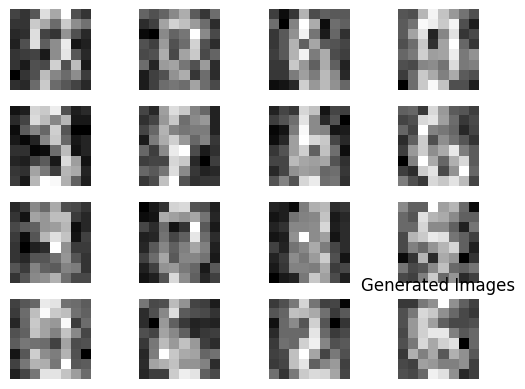

Epoch: 7, val nll=165.74200892857144
saved!


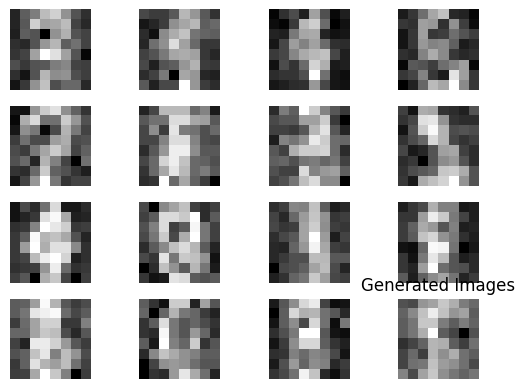

Epoch: 8, val nll=164.6599623325893
saved!


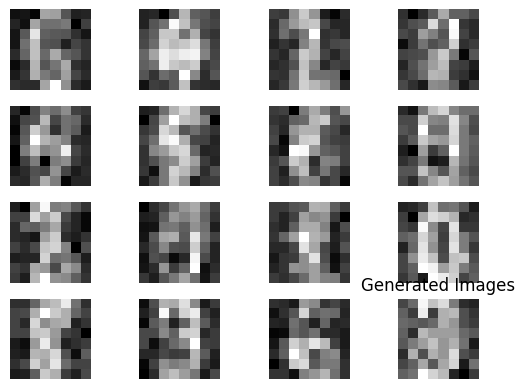

Epoch: 9, val nll=163.82735770089286
saved!


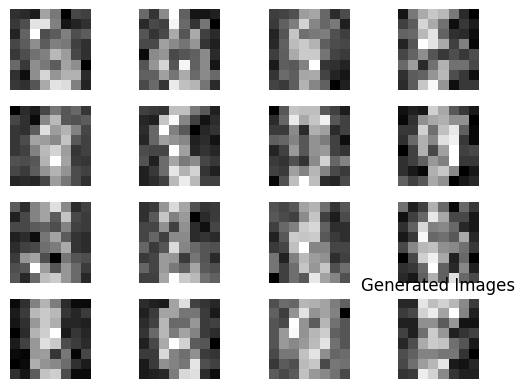

Epoch: 10, val nll=162.85913364955357
saved!


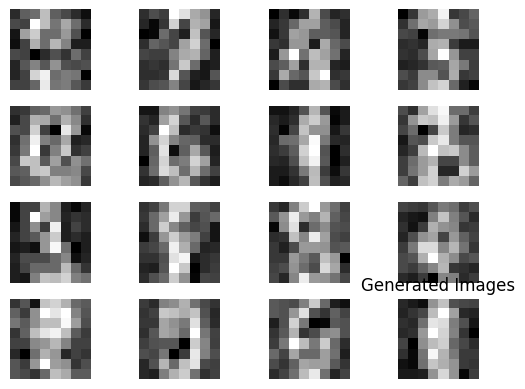

Epoch: 11, val nll=161.92037806919643
saved!


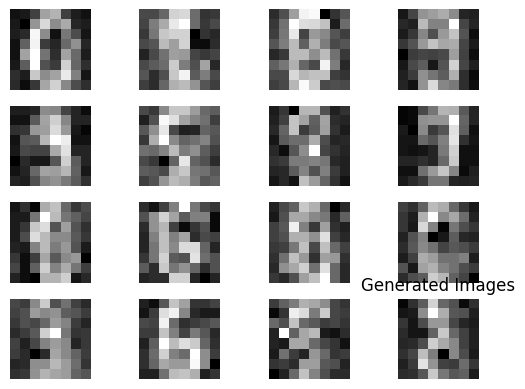

Epoch: 12, val nll=161.16453962053572
saved!


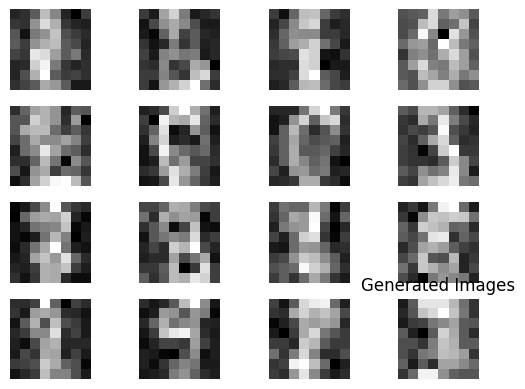

Epoch: 13, val nll=160.6172084263393
saved!


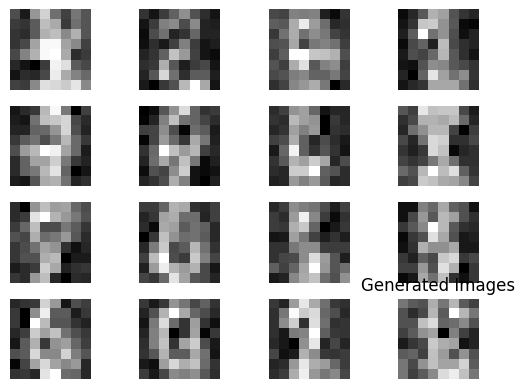

Epoch: 14, val nll=159.79843889508928
saved!


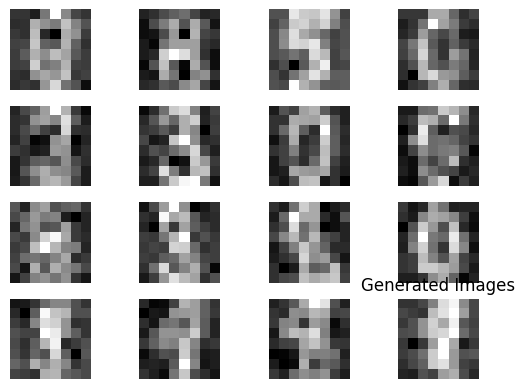

Epoch: 15, val nll=159.07175223214287
saved!


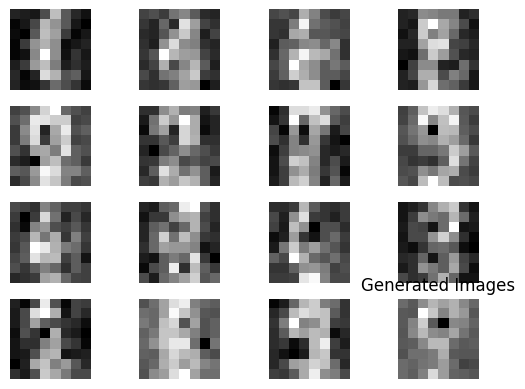

Epoch: 16, val nll=158.59624441964286
saved!


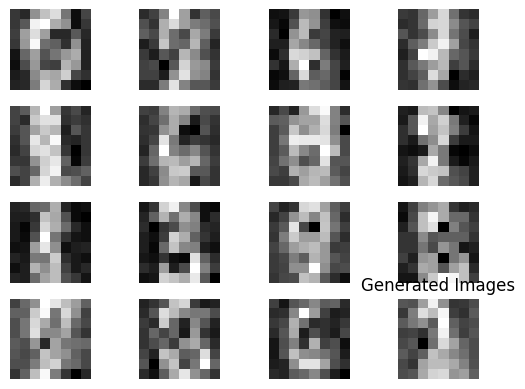

Epoch: 17, val nll=157.97992466517857
saved!


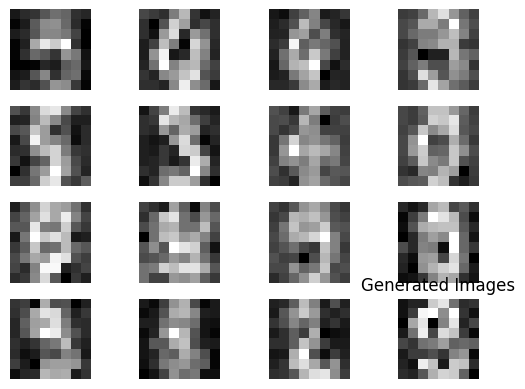

Epoch: 18, val nll=157.24739955357143
saved!


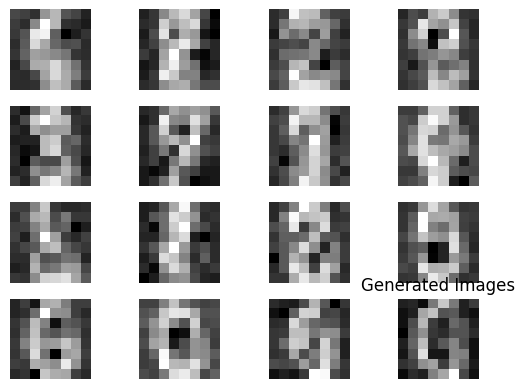

Epoch: 19, val nll=156.8576674107143
saved!


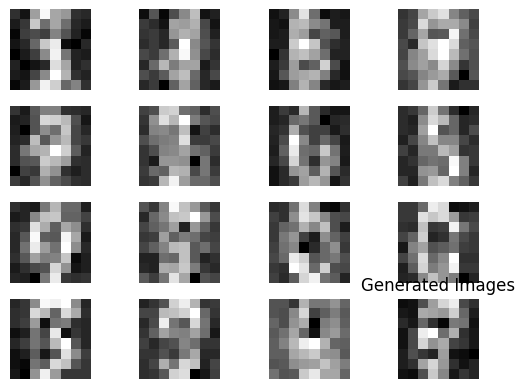

Epoch: 20, val nll=156.1128138950893
saved!


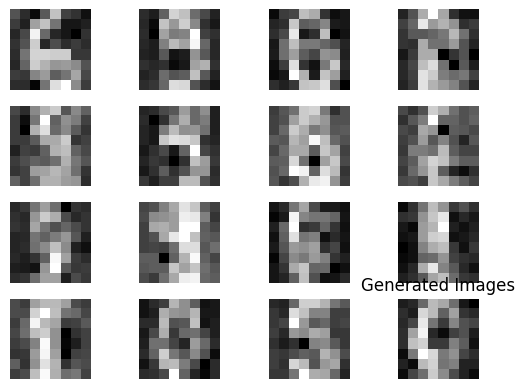

Epoch: 21, val nll=155.739677734375
saved!


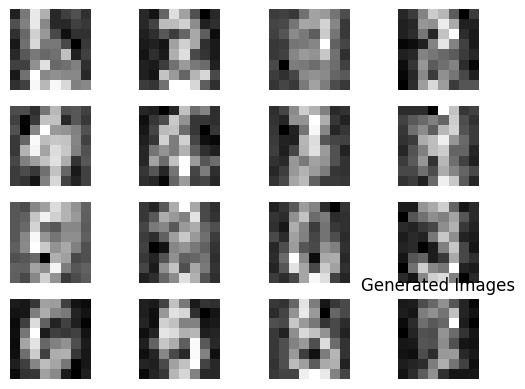

Epoch: 22, val nll=155.4662890625
saved!


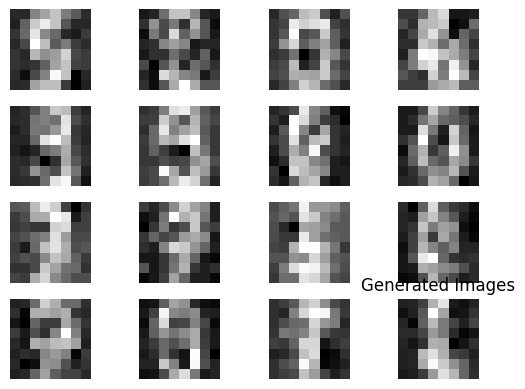

Epoch: 23, val nll=154.73629324776786
saved!


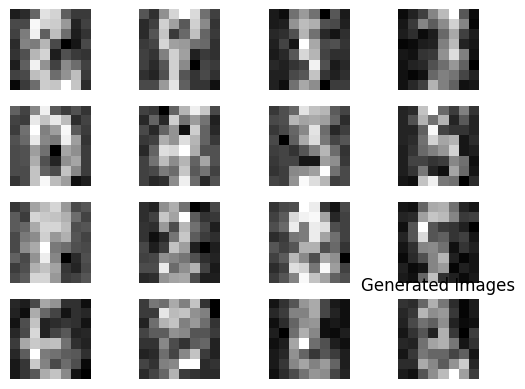

Epoch: 24, val nll=154.3148228236607
saved!


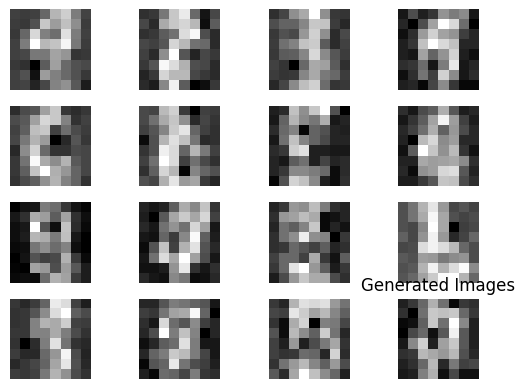

Epoch: 25, val nll=153.94001255580358
saved!


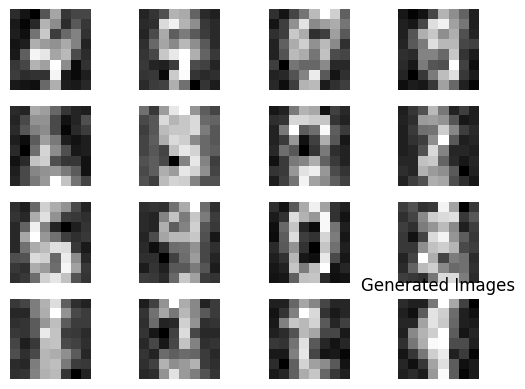

Epoch: 26, val nll=153.42178013392856
saved!


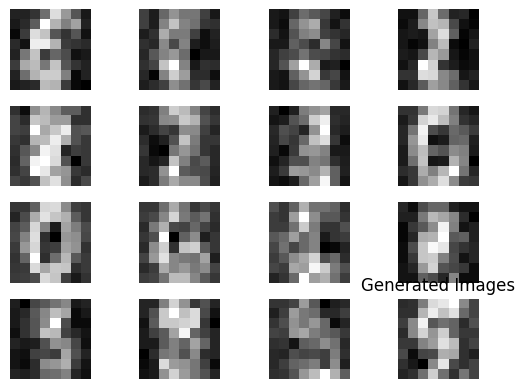

Epoch: 27, val nll=152.92462193080357
saved!


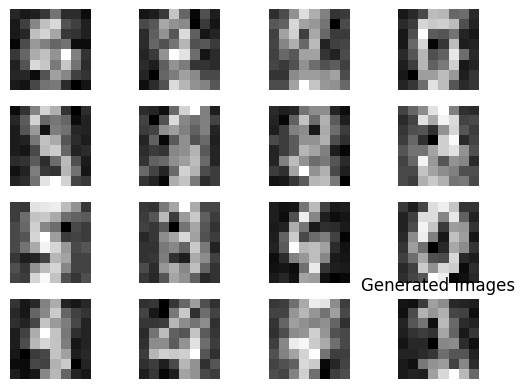

Epoch: 28, val nll=152.45433872767856
saved!


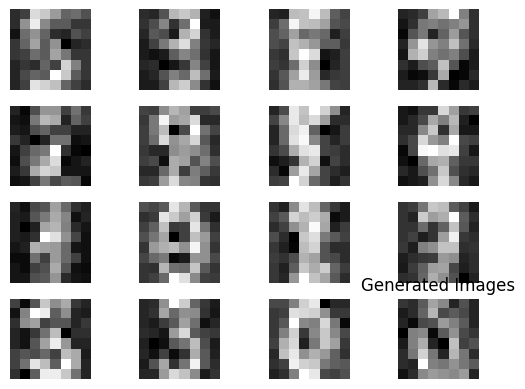

Epoch: 29, val nll=152.28090541294642
saved!


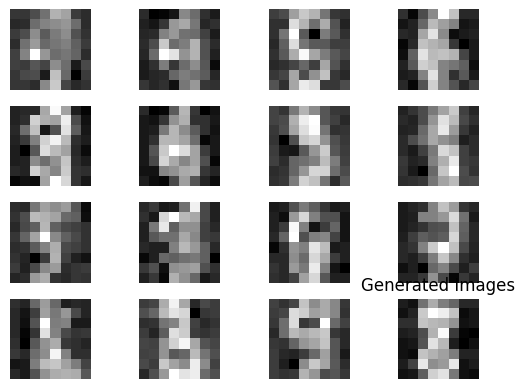

Epoch: 30, val nll=151.83700753348214
saved!


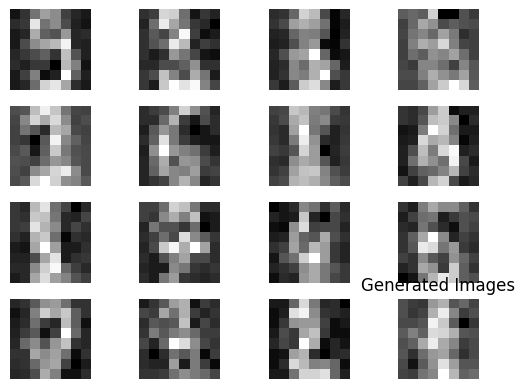

Epoch: 31, val nll=151.3118931361607
saved!


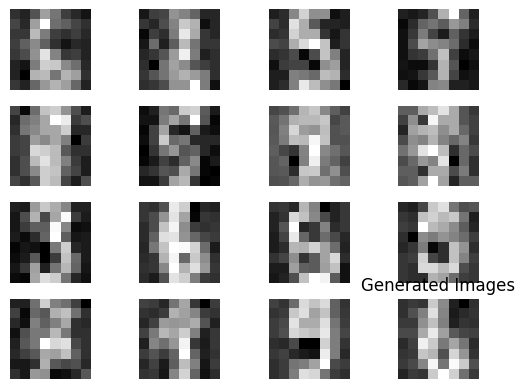

Epoch: 32, val nll=151.0000390625
saved!


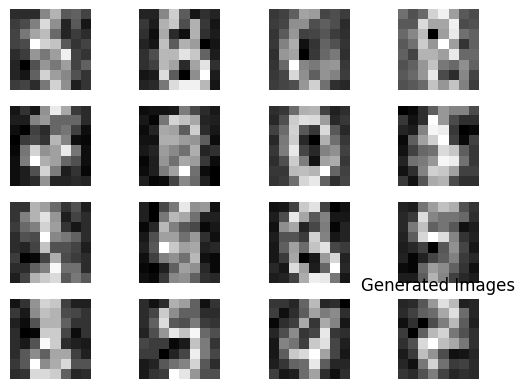

Epoch: 33, val nll=150.59670200892856
saved!


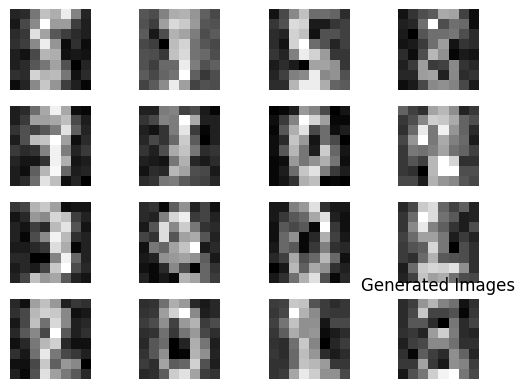

Epoch: 34, val nll=149.97182338169642
saved!


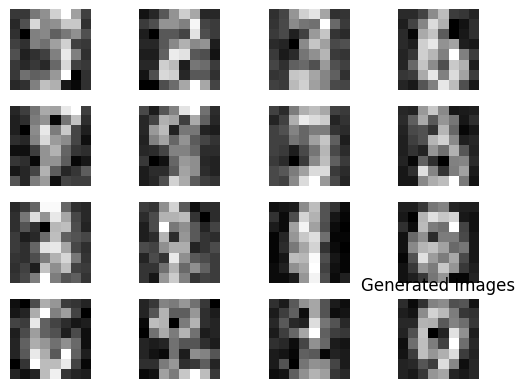

Epoch: 35, val nll=149.84709681919642
saved!


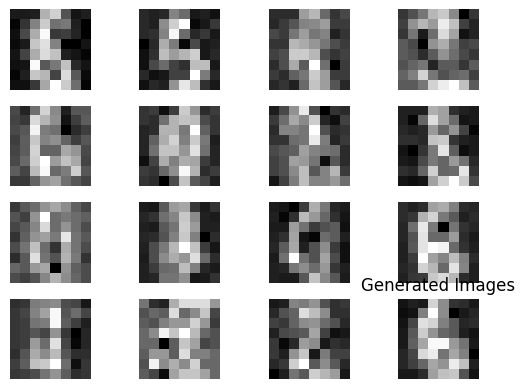

Epoch: 36, val nll=149.73296595982143
saved!


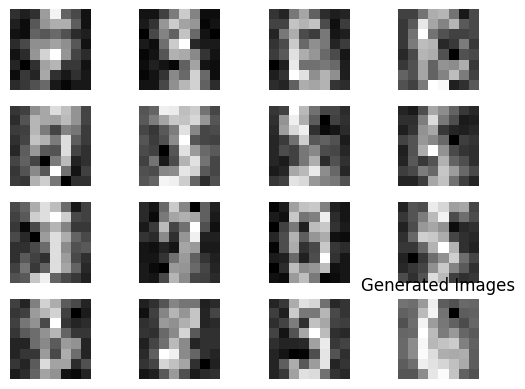

Epoch: 37, val nll=149.25834681919642
saved!


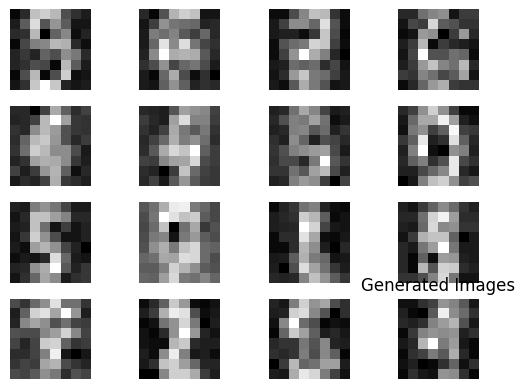

Epoch: 38, val nll=148.75892857142858
saved!


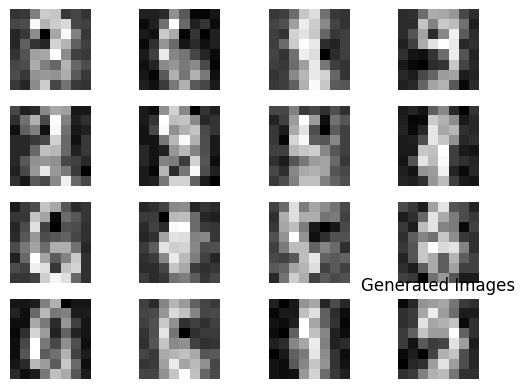

Epoch: 39, val nll=148.546396484375
saved!


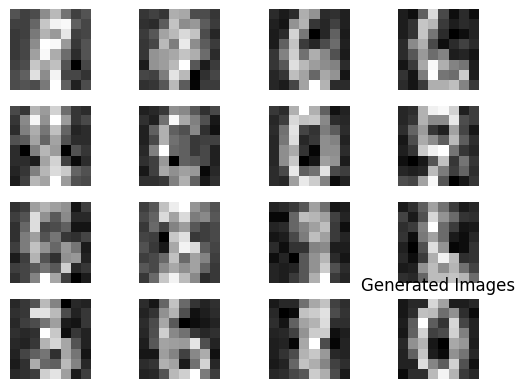

Epoch: 40, val nll=148.23430524553572
saved!


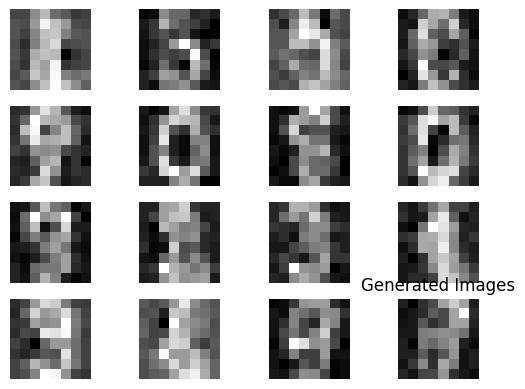

Epoch: 41, val nll=147.74815569196429
saved!


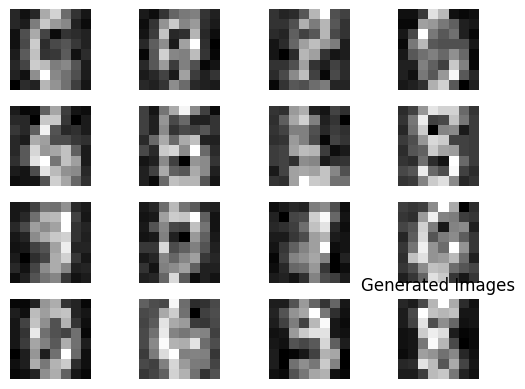

Epoch: 42, val nll=147.4599525669643
saved!


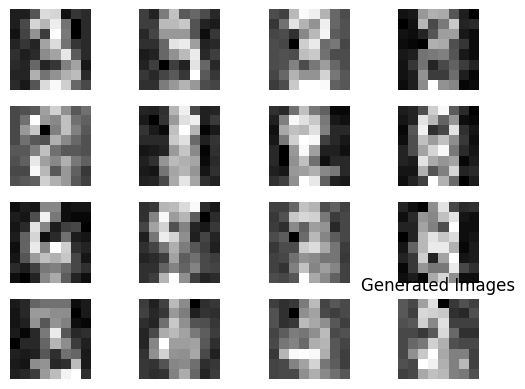

Epoch: 43, val nll=147.36003627232142
saved!


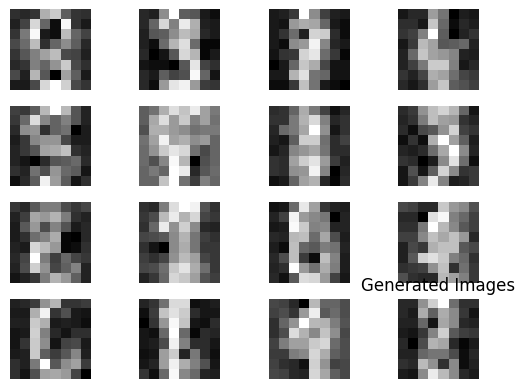

Epoch: 44, val nll=146.76026088169644
saved!


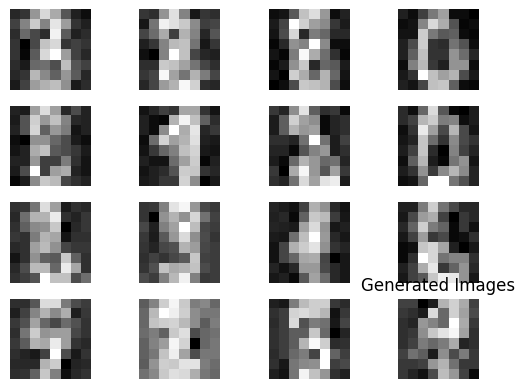

Epoch: 45, val nll=147.01514787946428
Epoch: 46, val nll=146.93925223214285
Epoch: 47, val nll=146.36441545758927
saved!


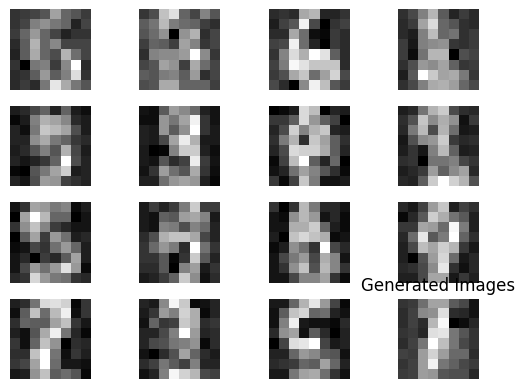

Epoch: 48, val nll=146.11308872767856
saved!


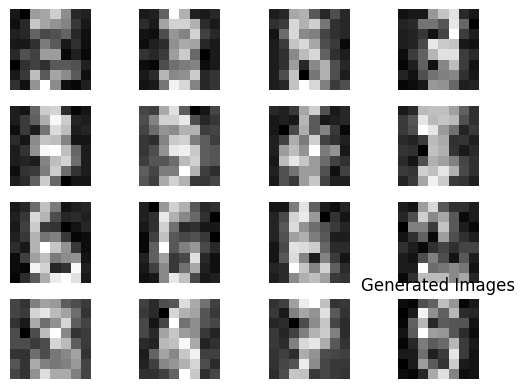

Epoch: 49, val nll=145.68844168526786
saved!


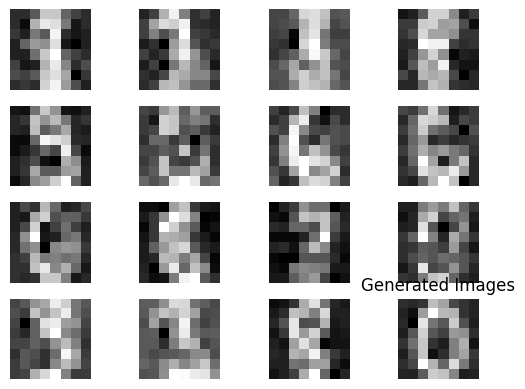

Epoch: 50, val nll=145.50434291294644
saved!


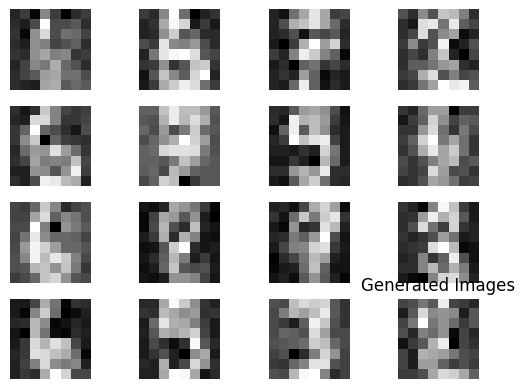

Epoch: 51, val nll=145.46706333705356
saved!


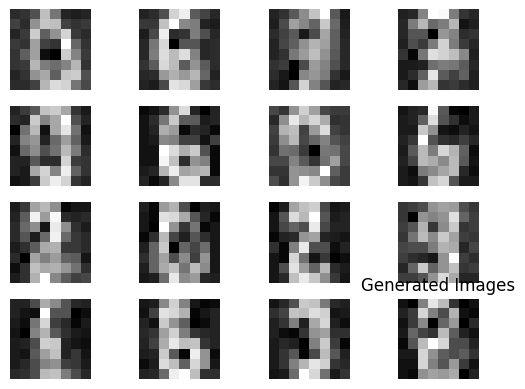

Epoch: 52, val nll=145.27918666294642
saved!


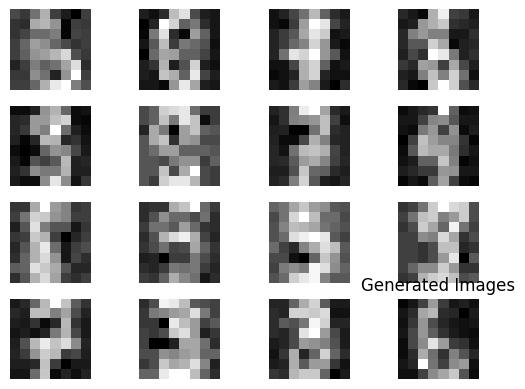

Epoch: 53, val nll=144.9799720982143
saved!


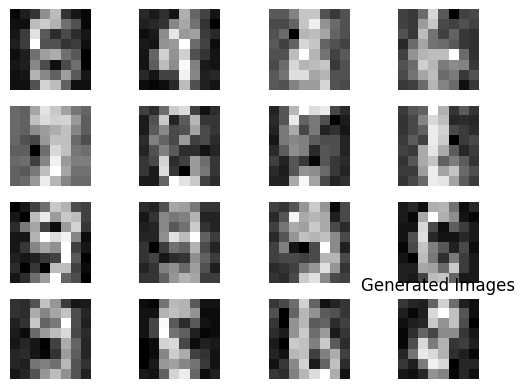

Epoch: 54, val nll=144.9616796875
saved!


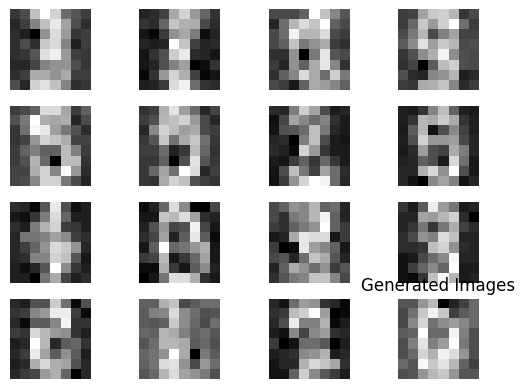

Epoch: 55, val nll=144.55948939732144
saved!


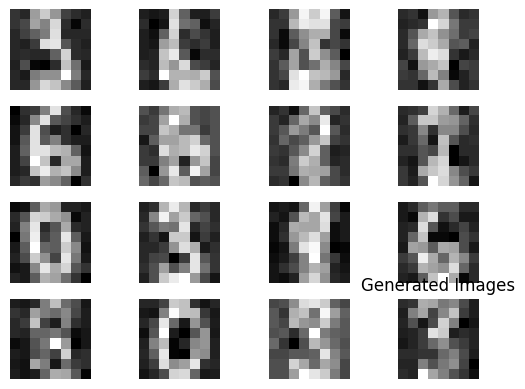

Epoch: 56, val nll=144.46177315848215
saved!


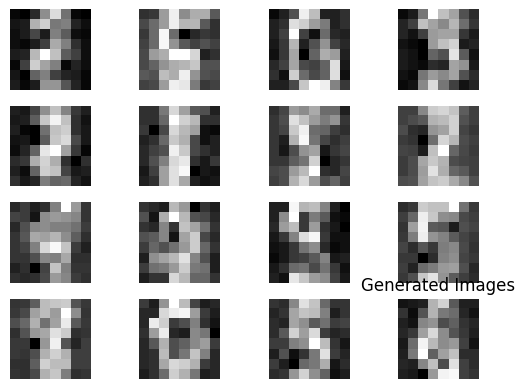

Epoch: 57, val nll=144.87060965401787
Epoch: 58, val nll=144.98359375
Epoch: 59, val nll=144.66652901785713
Epoch: 60, val nll=144.3469321986607
saved!


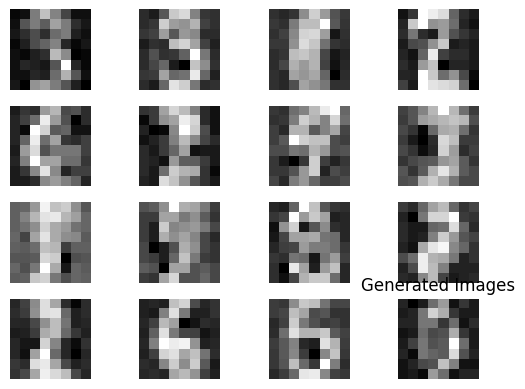

Epoch: 61, val nll=144.82359095982142
Epoch: 62, val nll=144.02491768973215
saved!


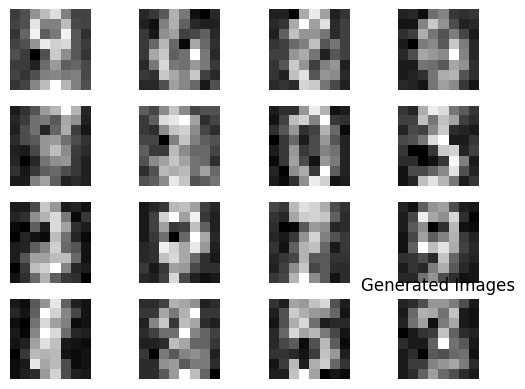

Epoch: 63, val nll=144.60401646205358
Epoch: 64, val nll=144.1297265625
Epoch: 65, val nll=144.18160016741072
Epoch: 66, val nll=143.76994559151785
saved!


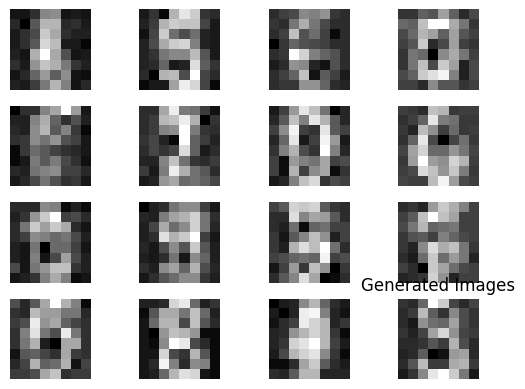

Epoch: 67, val nll=144.12963169642856
Epoch: 68, val nll=144.11313755580358
Epoch: 69, val nll=144.22598911830357
Epoch: 70, val nll=143.86843470982143
Epoch: 71, val nll=143.783515625
Epoch: 72, val nll=144.64159737723213
Epoch: 73, val nll=144.59416852678572
Epoch: 74, val nll=144.4021665736607
Epoch: 75, val nll=144.49962472098215
Epoch: 76, val nll=144.19038504464285
Epoch: 77, val nll=144.1811830357143
Epoch: 78, val nll=144.88736746651784
Epoch: 79, val nll=144.61657505580357
Epoch: 80, val nll=145.5339341517857
Epoch: 81, val nll=145.19671595982143
Epoch: 82, val nll=145.33851841517858
Epoch: 83, val nll=145.58814732142858
Epoch: 84, val nll=145.263369140625
Epoch: 85, val nll=145.84325613839286
Epoch: 86, val nll=146.81022042410714
Epoch: 87, val nll=146.42951311383928


In [22]:
# Training procedure
nll_val = training(name=result_dir + name, max_patience=max_patience, num_epochs=num_epochs, model=model, optimizer=optimizer,
                       training_loader=training_loader, val_loader=val_loader)

Final Loss: nll=142.47622824035236


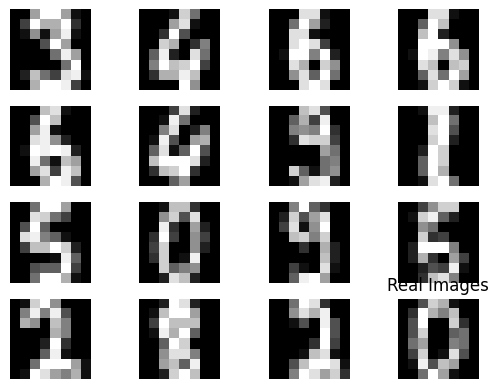

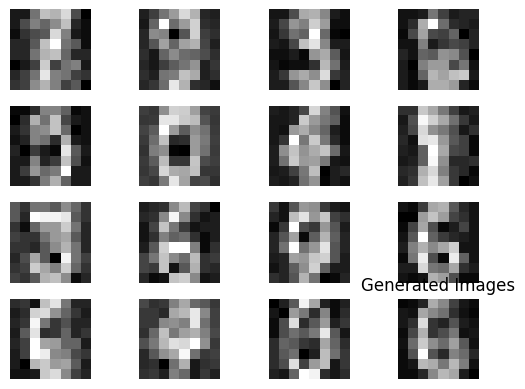

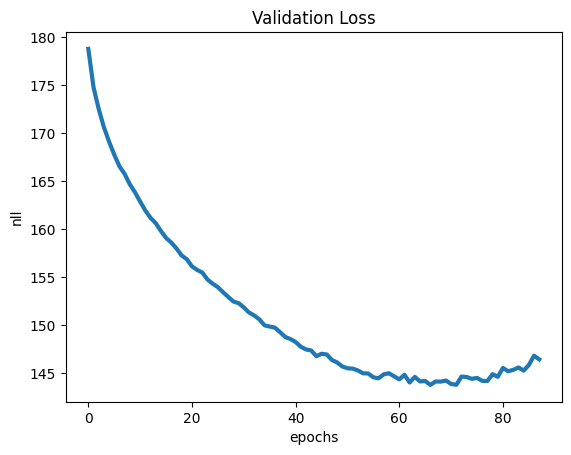

In [23]:
test_loss = evaluation(name=result_dir + name, test_loader=test_loader)
f = open(result_dir + name + '_test_loss.txt', "w")
f.write(str(test_loss))
f.close()

samples_real(result_dir + name, test_loader)

samples_generated(result_dir + name, test_loader)

plot_curve(result_dir + name, nll_val)

## **Bits-Per-Pixel (bpp) Calculation**

Bits-per-pixel (bpp) measures how efficiently a model encodes data. It represents the average number of bits needed to describe each pixel in your dataset. For a dataset of integer-valued samples $x_i \in \mathbb{Z}^D$ and a model that provides exact log-probabilities $\log p_\theta(x_i)$, bpp is computed as:

$$\text{bpp} = - \frac{1}{N \cdot D} \sum_{i=1}^{N} \log_2 p_\theta(x_i)$$

where:  
- $N$ = number of samples  
- $D$ = number of pixels per sample  

**Task:**  

1. Use the trained **RealNVP** and **IDF** model to compute log-probabilities for all samples in the **test set**.  
2. Use these log-probabilities to calculate the **bits-per-pixel (bpp)** for the test set.

In [24]:
# Bits-Per-Pixel (bpp) calculation for RealNVP and IDF on the test set

import math
import torch

# Helper: compute bpp for a generic flow model that returns exact log p(x)
def compute_bpp_from_logpx(logpx_list, D):
    """
    logpx_list: list of 1D tensors containing log p(x_i) in natural log
    D:         number of pixels / dimensions
    """
    logpx_all = torch.cat(logpx_list, dim=0)   # shape: [N]
    N = logpx_all.size(0)
    # Convert natural log to log base 2 by dividing by ln(2)
    bpp = -logpx_all.sum().item() / (N * D * math.log(2.0))
    return bpp


# RealNVP:

# Rebuild RealNVP and load best checkpoint
prior_realnvp = prior  # prior already defined in the RealNVP section
realnvp_model = RealNVP(nets, nett, num_flows, prior_realnvp, D=D, dequantization=True)
realnvp_model.load_state_dict(torch.load(os.path.join(result_dir, 'realnvp.model')))
realnvp_model.eval()

realnvp_logpx = []

with torch.no_grad():
    for batch in test_loader:
        x = batch

        # Apply the same dequantization as in evaluation()
        if hasattr(realnvp_model, 'dequantization') and realnvp_model.dequantization:
            x = x + (1. - torch.rand(x.shape)) / 2.

        # x -> z
        z, log_det_J = realnvp_model.f(x)

        # log p(x) = log p(z) + log |det J|
        log_px = realnvp_model.prior.log_prob(z) + log_det_J  # shape: [batch]
        realnvp_logpx.append(log_px)

bpp_realnvp = compute_bpp_from_logpx(realnvp_logpx, D)


# IDF:

# Rebuild IDF and load best checkpoint
idf_model = IDF(netts, num_flows, D=D)
idf_model.load_state_dict(torch.load(os.path.join(result_dir, 'idf.model')))
idf_model.eval()

idf_logpx = []

with torch.no_grad():
    for batch in test_loader:
        x = batch

        # For IDF, the log-likelihood is given by log_prior(f(x))
        z = idf_model.f(x)
        log_px = idf_model.log_prior(z)  # shape: [batch]
        idf_logpx.append(log_px)

bpp_idf = compute_bpp_from_logpx(idf_logpx, D)


# Print results
print(f"Test bits-per-pixel (bpp) for RealNVP: {bpp_realnvp:.4f}")
print(f"Test bits-per-pixel (bpp) for IDF:     {bpp_idf:.4f}")


Test bits-per-pixel (bpp) for RealNVP: 2.6532
Test bits-per-pixel (bpp) for IDF:     3.2117


### **Questions **

- **Q10:** Compare the quality of generated samples from RealNVP and IDF. What differences do you notice?
- **Q11:** Compare the bpp values obtained from the two models (RealNVP vs IDF). Explain why is suitable for **lossless compression**?

**Your Answer:**

- **Q10:**  

  Visually, the generated samples from **RealNVP** and **IDF** differ in a way that matches their underlying modeling assumptions:

  - **RealNVP** operates in a *continuous* space with dequantization. Its samples tend to look relatively **smooth**: pixel intensities vary continuously, and strokes of the digits can appear slightly blurred or “soft”, because the model is free to produce any real-valued intensities, not just the original discrete levels.
  - **IDF**, in contrast, is a *discrete* flow operating directly on integer-valued data. Its generative process uses integer-preserving transformations plus a discrete prior. As a result, its samples tend to look more **“pixelated” or blocky**, with sharper transitions between intensities and values that are closer to the original discrete grid. In some cases, this can also mean samples look slightly noisier or less smooth, because the model jumps between discrete levels rather than interpolating continuously.

  Overall, RealNVP samples often look smoother and more continuous, while IDF samples better respect the discrete nature of the data but may look less smooth and more “grid-like”. This matches the idea that RealNVP models a dequantized continuous version of the digits, whereas IDF is designed explicitly for integer data.


- **Q11:**  

  In my experiments, the test bits-per-pixel (bpp) values were:

  $$
  \text{bpp}_{\text{RealNVP}} \approx 2.6532, \qquad
  \text{bpp}_{\text{IDF}} \approx 3.2117.
  $$

  Since bpp is defined as
  $$
  \text{bpp} = -\frac{1}{N \cdot D} \sum_{i=1}^N \log_2 p_\theta(x_i),
  $$
  a **lower** bpp means the model assigns **higher probability** to the data and can, in principle, compress it more efficiently: the ideal code length per pixel is roughly the bpp. According to these numbers, RealNVP achieves better compression (on this dequantized continuous version of the data) than IDF.

  For **lossless compression**, what matters conceptually is that:
  1. The model provides a **valid probability distribution** over the (discrete) data,
  2. We can evaluate \( p_\theta(x) \) (or \(\log_2 p_\theta(x)\)) for each sample,
  3. We can then use an **entropy coder** (e.g., arithmetic coding) that encodes each symbol with approximately \(-\log_2 p_\theta(x)\) bits.

  A model like **IDF** is especially natural for **lossless compression of integer data** because:
  - It defines a proper **discrete** distribution over \( \mathbb{Z}^D \),
  - The flow \(f\) is a bijection on the integer lattice, so probability mass is rearranged exactly,
  - The log-probabilities correspond directly to code lengths in bits for exact integer-valued samples.

  RealNVP can also be used for compression, but it models a **continuous, dequantized** version of the data, so there is an extra conceptual step to connect its continuous density to a discrete code. IDF, being discrete and invertible on integers, aligns more directly with the setting of **lossless compression**, even if in this particular experiment its empirical bpp is higher than RealNVP’s.

Running IDF dequantization experiment...
Epoch: 0, val nll=179.43024553571428
[IDF-dequant] epoch 0, val NLL = 179.4302
saved!


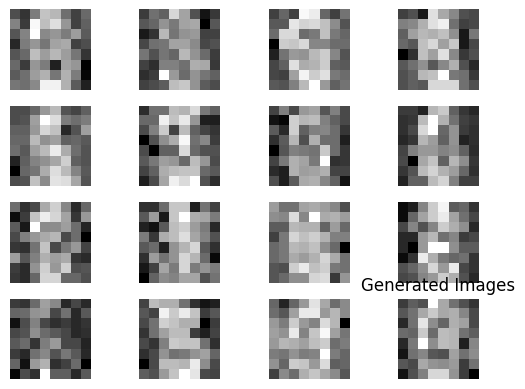

Epoch: 1, val nll=175.19562918526785
[IDF-dequant] epoch 1, val NLL = 175.1956
saved!


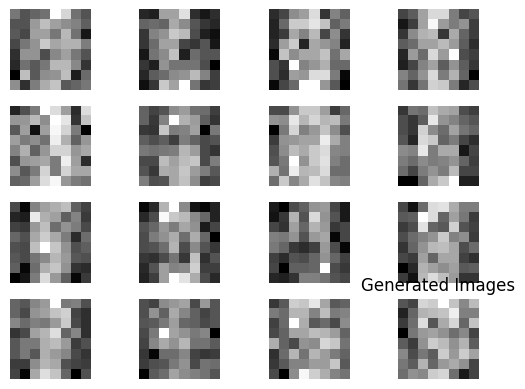

Epoch: 2, val nll=173.20785853794644
[IDF-dequant] epoch 2, val NLL = 173.2079
saved!


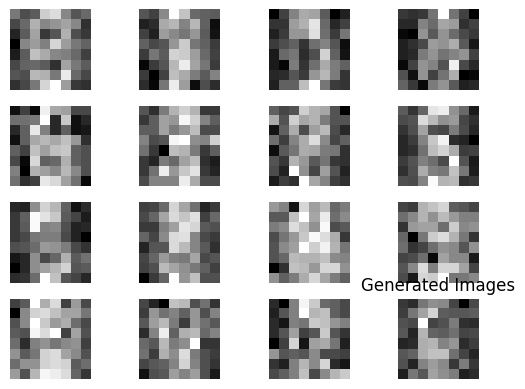

Epoch: 3, val nll=171.23062779017857
[IDF-dequant] epoch 3, val NLL = 171.2306
saved!


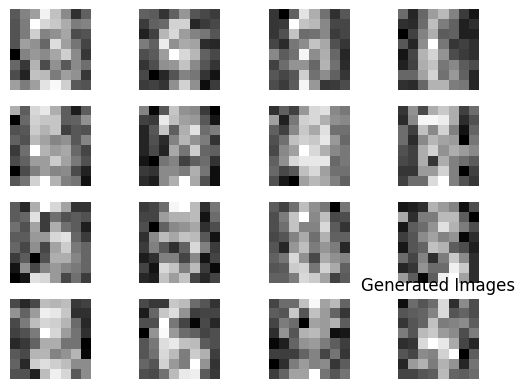

Epoch: 4, val nll=169.69298828125
[IDF-dequant] epoch 4, val NLL = 169.6930
saved!


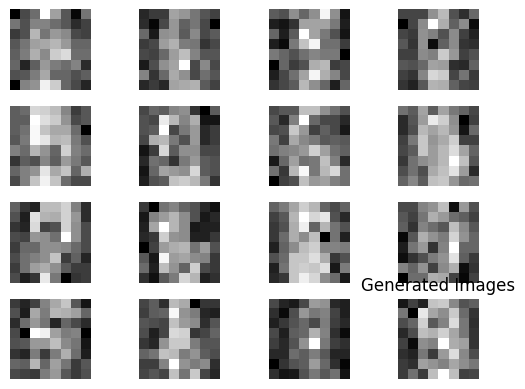

Epoch: 5, val nll=168.27073939732142
[IDF-dequant] epoch 5, val NLL = 168.2707
saved!


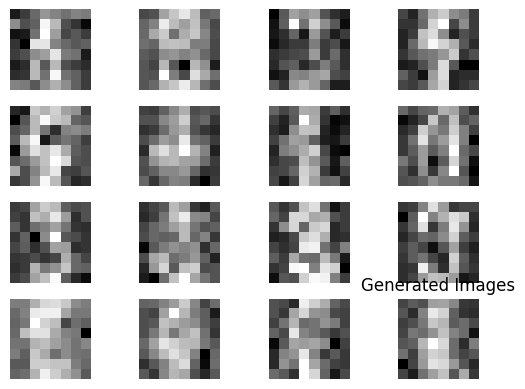

Epoch: 6, val nll=166.98783761160715
[IDF-dequant] epoch 6, val NLL = 166.9878
saved!


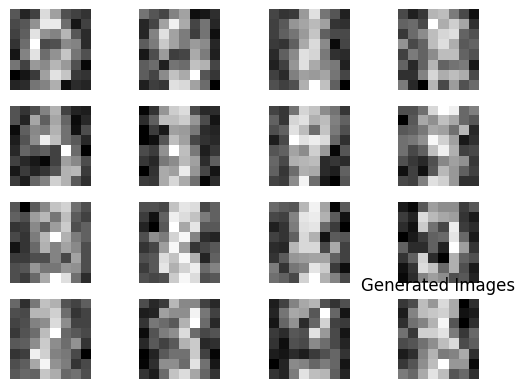

Epoch: 7, val nll=165.98835797991072
[IDF-dequant] epoch 7, val NLL = 165.9884
saved!


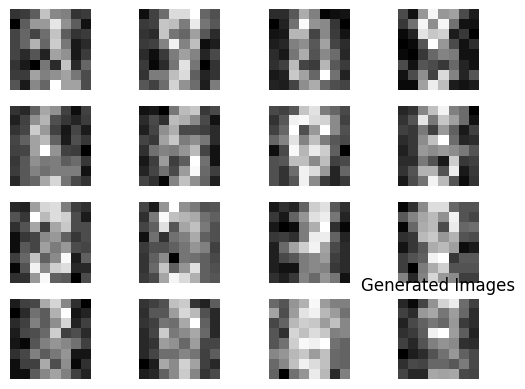

Epoch: 8, val nll=165.0398256138393
[IDF-dequant] epoch 8, val NLL = 165.0398
saved!


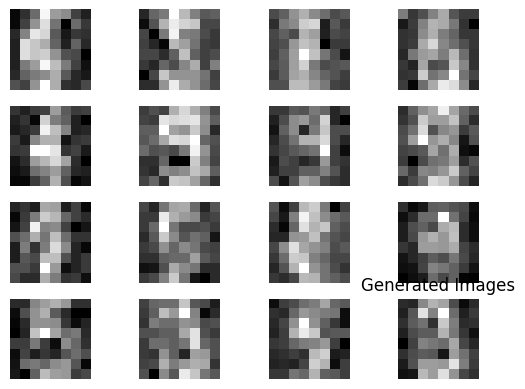

Epoch: 9, val nll=164.26357979910713
[IDF-dequant] epoch 9, val NLL = 164.2636
saved!


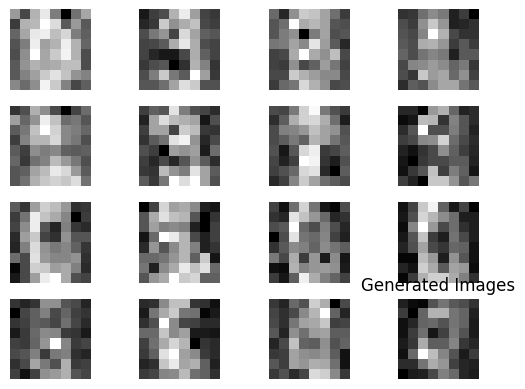

Epoch: 10, val nll=163.19346819196429
[IDF-dequant] epoch 10, val NLL = 163.1935
saved!


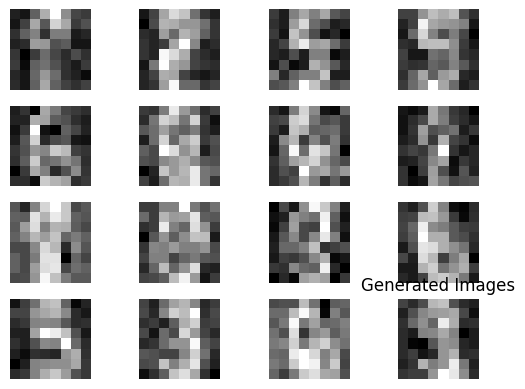

Epoch: 11, val nll=162.42736886160714
[IDF-dequant] epoch 11, val NLL = 162.4274
saved!


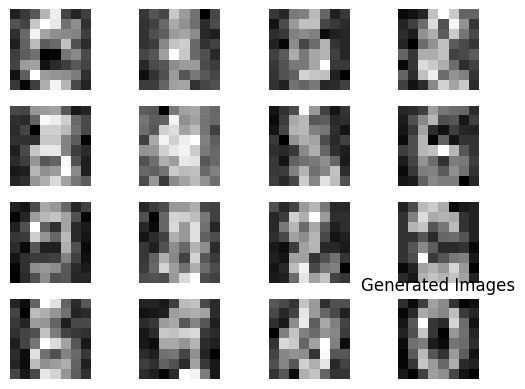

Epoch: 12, val nll=161.91664620535715
[IDF-dequant] epoch 12, val NLL = 161.9166
saved!


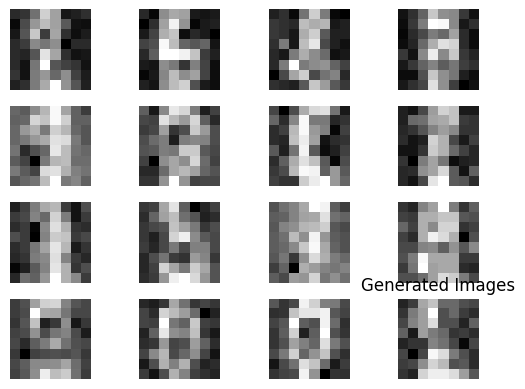

Epoch: 13, val nll=161.1040053013393
[IDF-dequant] epoch 13, val NLL = 161.1040
saved!


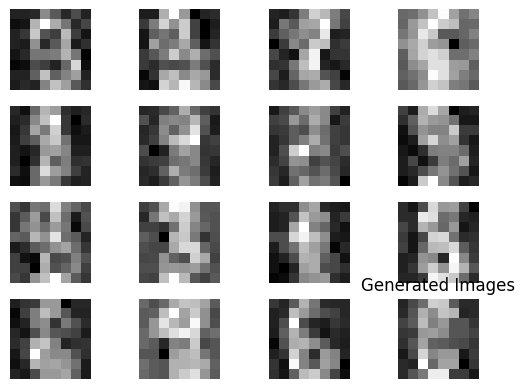

Epoch: 14, val nll=160.41907924107142
[IDF-dequant] epoch 14, val NLL = 160.4191
saved!


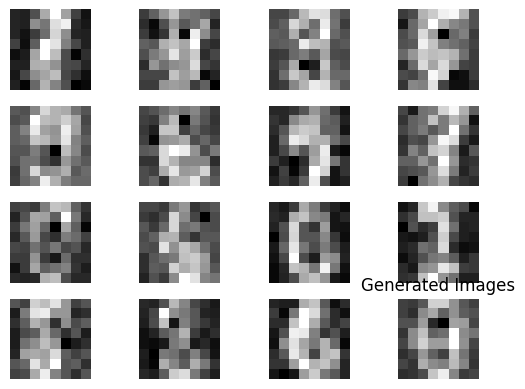

Epoch: 15, val nll=160.10810965401785
[IDF-dequant] epoch 15, val NLL = 160.1081
saved!


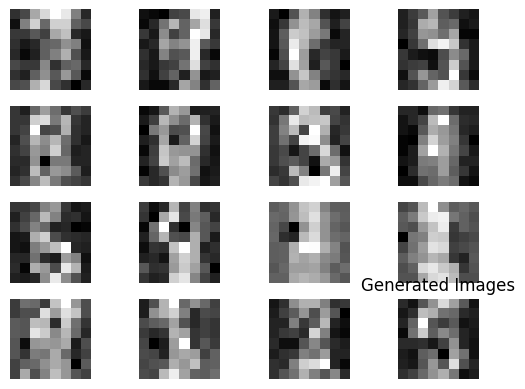

Epoch: 16, val nll=159.21409319196428
[IDF-dequant] epoch 16, val NLL = 159.2141
saved!


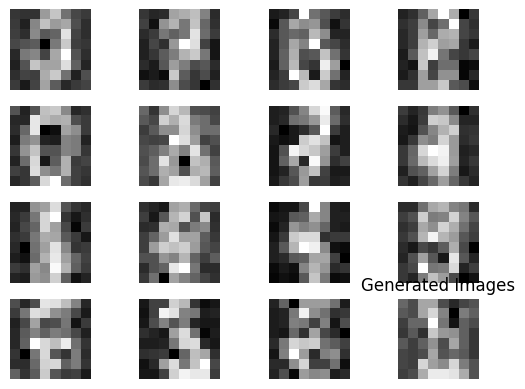

Epoch: 17, val nll=158.60895786830358
[IDF-dequant] epoch 17, val NLL = 158.6090
saved!


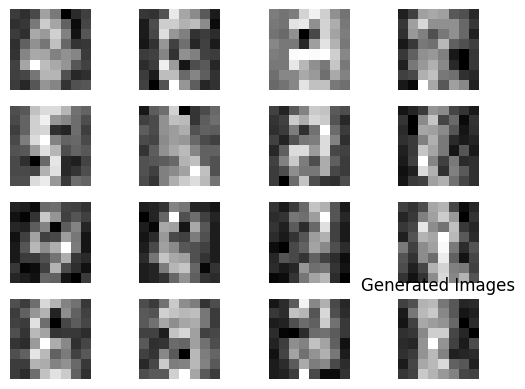

Epoch: 18, val nll=158.36487583705357
[IDF-dequant] epoch 18, val NLL = 158.3649
saved!


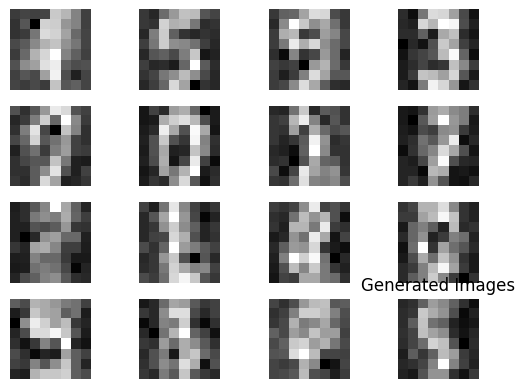

Epoch: 19, val nll=157.70906808035716
[IDF-dequant] epoch 19, val NLL = 157.7091
saved!


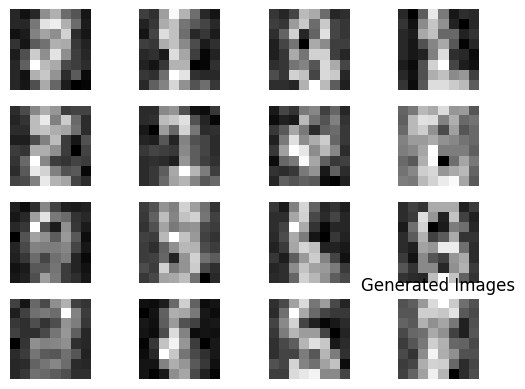

Epoch: 20, val nll=157.12028738839285
[IDF-dequant] epoch 20, val NLL = 157.1203
saved!


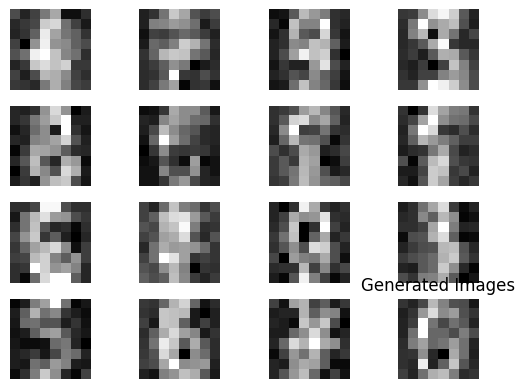

Epoch: 21, val nll=156.4862611607143
[IDF-dequant] epoch 21, val NLL = 156.4863
saved!


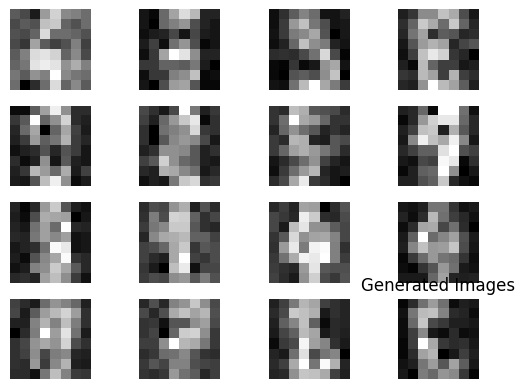

Epoch: 22, val nll=155.95275809151786
[IDF-dequant] epoch 22, val NLL = 155.9528
saved!


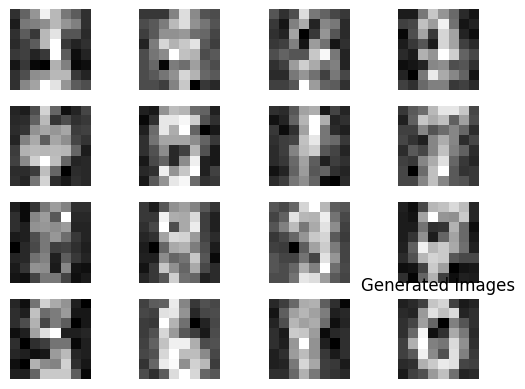

Epoch: 23, val nll=155.66342215401787
[IDF-dequant] epoch 23, val NLL = 155.6634
saved!


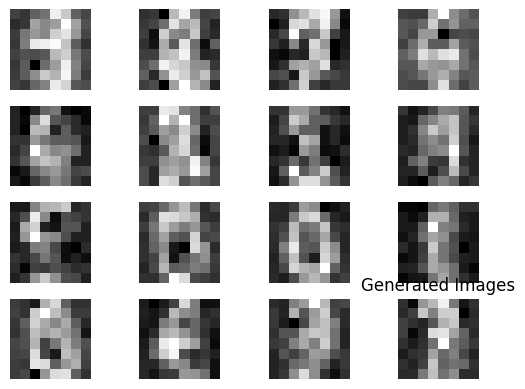

Epoch: 24, val nll=155.114541015625
[IDF-dequant] epoch 24, val NLL = 155.1145
saved!


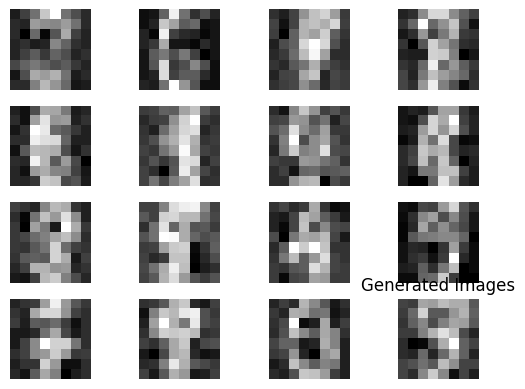

Epoch: 25, val nll=155.15642996651786
[IDF-dequant] epoch 25, val NLL = 155.1564
Epoch: 26, val nll=154.1888169642857
[IDF-dequant] epoch 26, val NLL = 154.1888
saved!


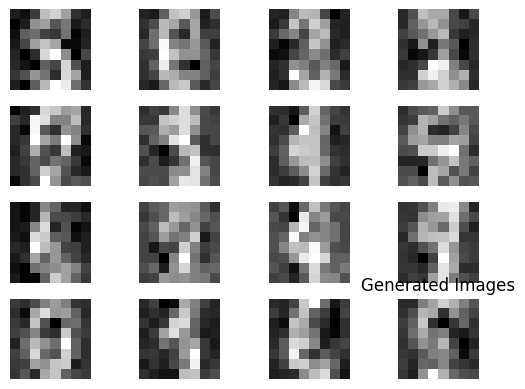

Epoch: 27, val nll=153.98595982142857
[IDF-dequant] epoch 27, val NLL = 153.9860
saved!


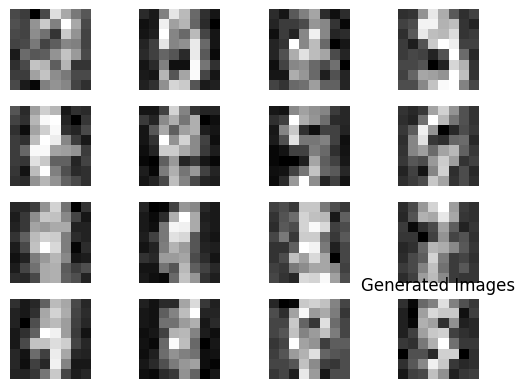

Epoch: 28, val nll=153.482197265625
[IDF-dequant] epoch 28, val NLL = 153.4822
saved!


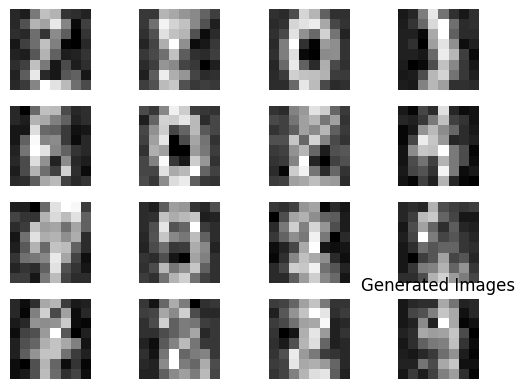

Epoch: 29, val nll=153.29270786830358
[IDF-dequant] epoch 29, val NLL = 153.2927
saved!


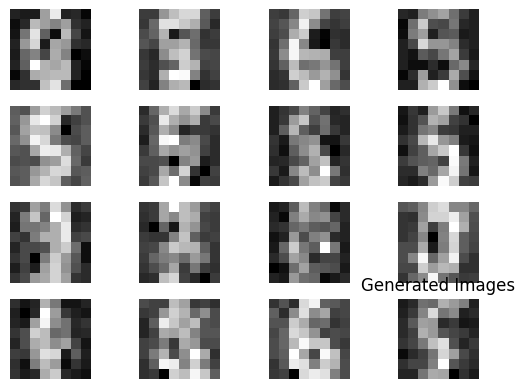

Epoch: 30, val nll=153.02777064732143
[IDF-dequant] epoch 30, val NLL = 153.0278
saved!


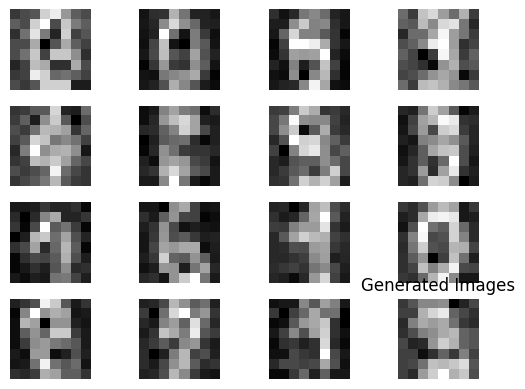

Epoch: 31, val nll=152.43892020089285
[IDF-dequant] epoch 31, val NLL = 152.4389
saved!


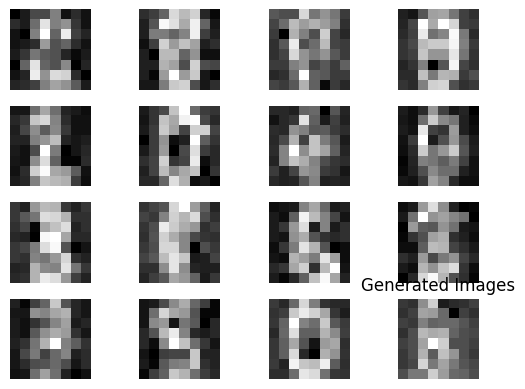

Epoch: 32, val nll=152.07883370535714
[IDF-dequant] epoch 32, val NLL = 152.0788
saved!


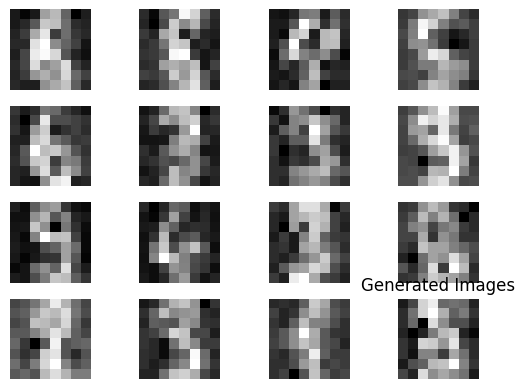

Epoch: 33, val nll=151.45997209821428
[IDF-dequant] epoch 33, val NLL = 151.4600
saved!


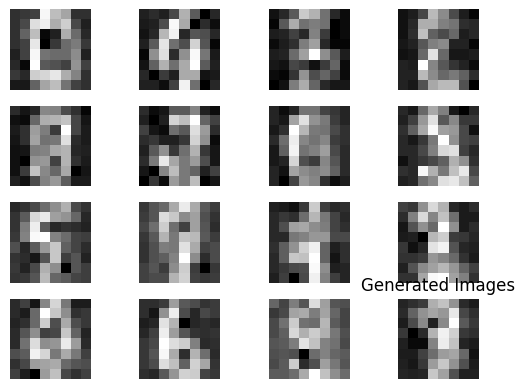

Epoch: 34, val nll=151.5956947544643
[IDF-dequant] epoch 34, val NLL = 151.5957
Epoch: 35, val nll=150.8969921875
[IDF-dequant] epoch 35, val NLL = 150.8970
saved!


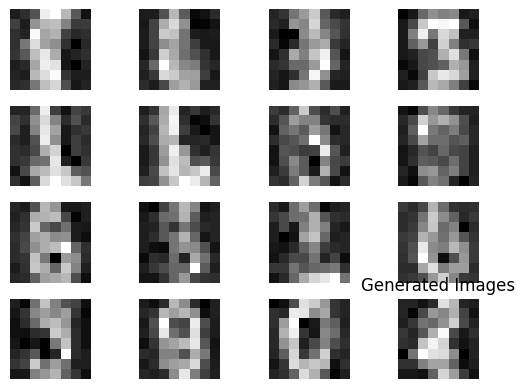

Epoch: 36, val nll=150.65342354910715
[IDF-dequant] epoch 36, val NLL = 150.6534
saved!


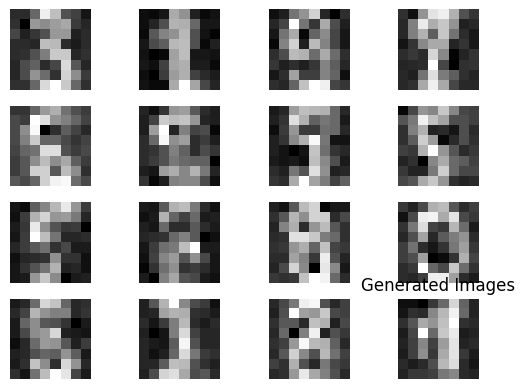

Epoch: 37, val nll=150.64390485491072
[IDF-dequant] epoch 37, val NLL = 150.6439
saved!


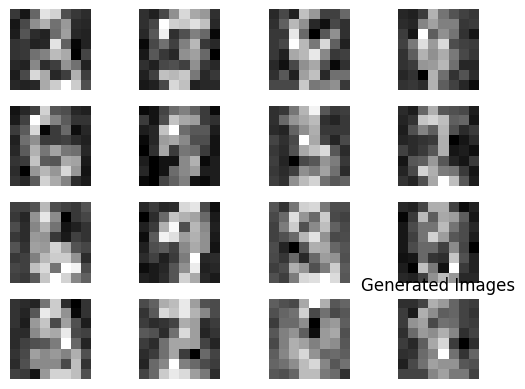

Epoch: 38, val nll=149.83458565848215
[IDF-dequant] epoch 38, val NLL = 149.8346
saved!


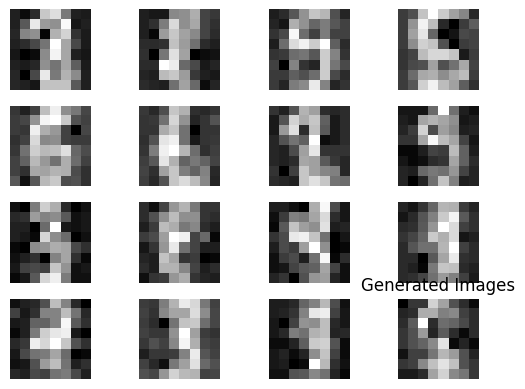

Epoch: 39, val nll=149.5935072544643
[IDF-dequant] epoch 39, val NLL = 149.5935
saved!


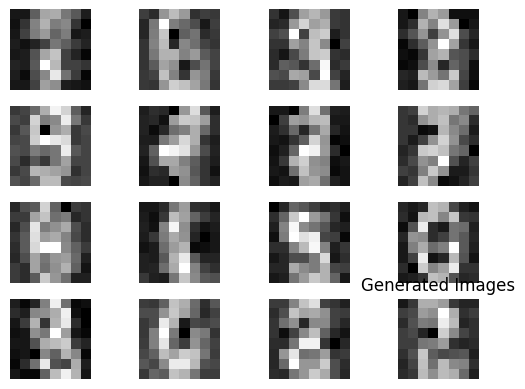

Epoch: 40, val nll=149.87399135044643
[IDF-dequant] epoch 40, val NLL = 149.8740
Epoch: 41, val nll=149.4861049107143
[IDF-dequant] epoch 41, val NLL = 149.4861
saved!


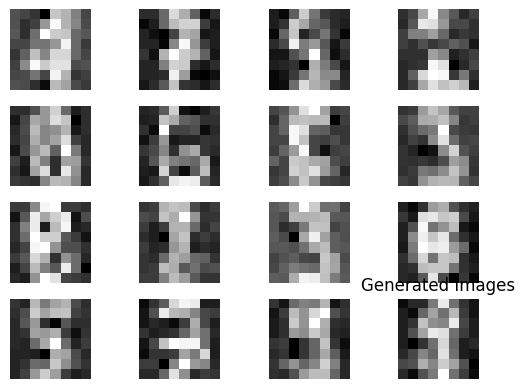

Epoch: 42, val nll=148.9760365513393
[IDF-dequant] epoch 42, val NLL = 148.9760
saved!


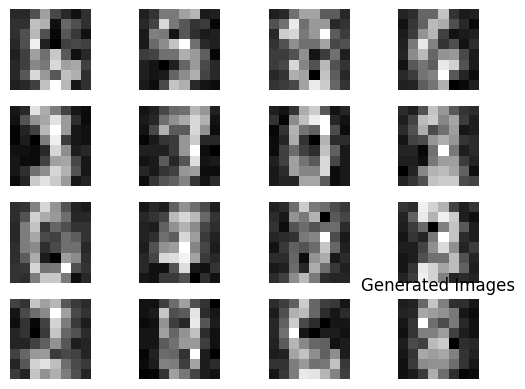

Epoch: 43, val nll=148.577158203125
[IDF-dequant] epoch 43, val NLL = 148.5772
saved!


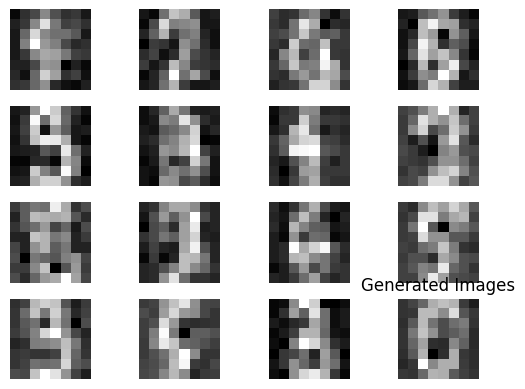

Epoch: 44, val nll=148.22095982142858
[IDF-dequant] epoch 44, val NLL = 148.2210
saved!


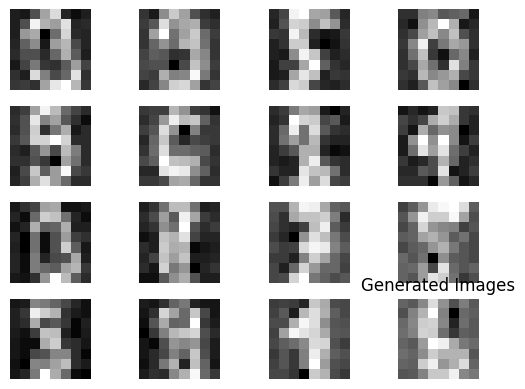

Epoch: 45, val nll=148.2722544642857
[IDF-dequant] epoch 45, val NLL = 148.2723
Epoch: 46, val nll=148.2838462611607
[IDF-dequant] epoch 46, val NLL = 148.2838
Epoch: 47, val nll=147.31020228794642
[IDF-dequant] epoch 47, val NLL = 147.3102
saved!


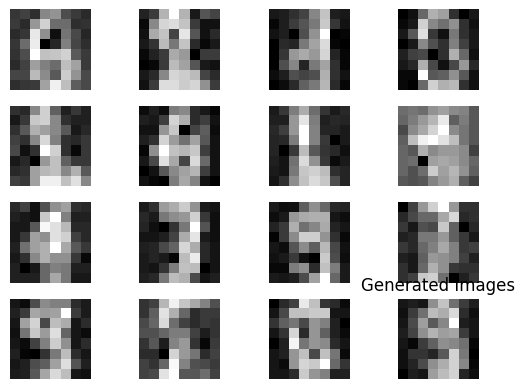

Epoch: 48, val nll=146.83988560267858
[IDF-dequant] epoch 48, val NLL = 146.8399
saved!


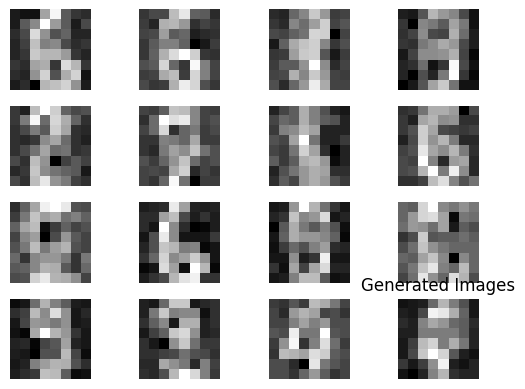

Epoch: 49, val nll=147.37568777901785
[IDF-dequant] epoch 49, val NLL = 147.3757
Epoch: 50, val nll=147.16166573660715
[IDF-dequant] epoch 50, val NLL = 147.1617
Epoch: 51, val nll=146.90451729910714
[IDF-dequant] epoch 51, val NLL = 146.9045
Epoch: 52, val nll=146.79337193080357
[IDF-dequant] epoch 52, val NLL = 146.7934
saved!


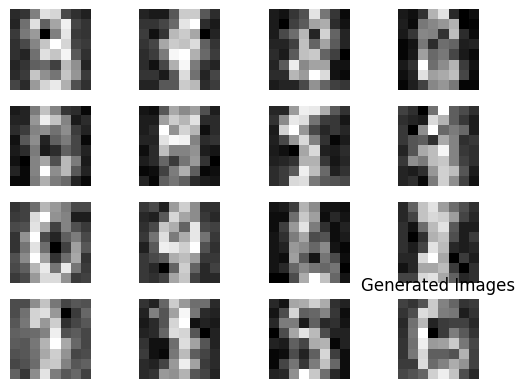

Epoch: 53, val nll=146.142890625
[IDF-dequant] epoch 53, val NLL = 146.1429
saved!


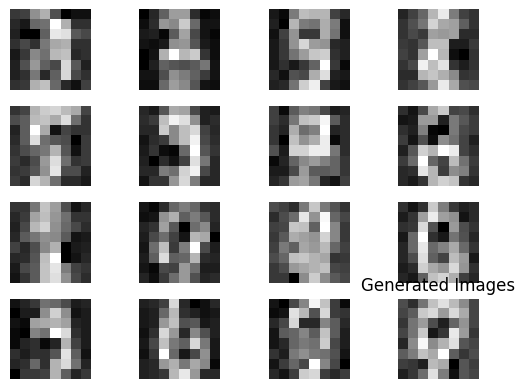

Epoch: 54, val nll=146.37407784598216
[IDF-dequant] epoch 54, val NLL = 146.3741
Epoch: 55, val nll=146.00136300223215
[IDF-dequant] epoch 55, val NLL = 146.0014
saved!


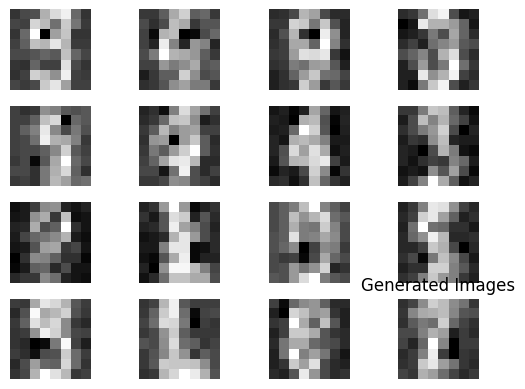

Epoch: 56, val nll=145.71484095982143
[IDF-dequant] epoch 56, val NLL = 145.7148
saved!


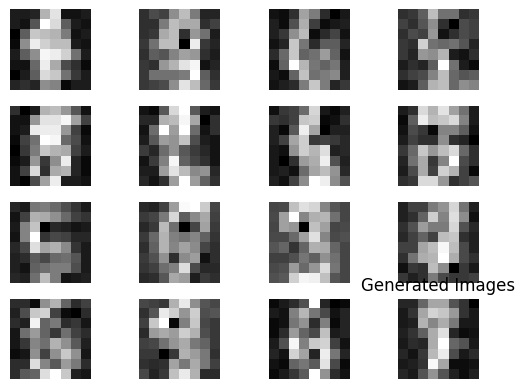

Epoch: 57, val nll=146.02176478794644
[IDF-dequant] epoch 57, val NLL = 146.0218
Epoch: 58, val nll=145.78684012276787
[IDF-dequant] epoch 58, val NLL = 145.7868
Epoch: 59, val nll=145.8599818638393
[IDF-dequant] epoch 59, val NLL = 145.8600
Epoch: 60, val nll=145.83716936383928
[IDF-dequant] epoch 60, val NLL = 145.8372
Epoch: 61, val nll=145.17923549107144
[IDF-dequant] epoch 61, val NLL = 145.1792
saved!


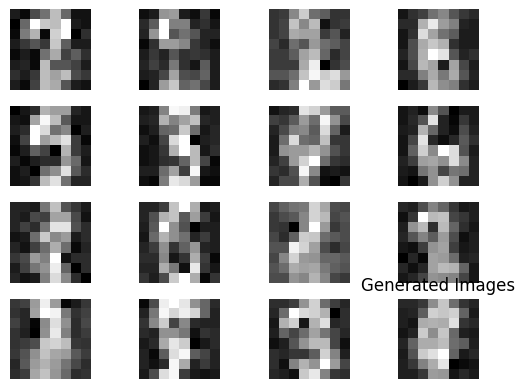

Epoch: 62, val nll=145.1914662388393
[IDF-dequant] epoch 62, val NLL = 145.1915
Epoch: 63, val nll=144.92750279017858
[IDF-dequant] epoch 63, val NLL = 144.9275
saved!


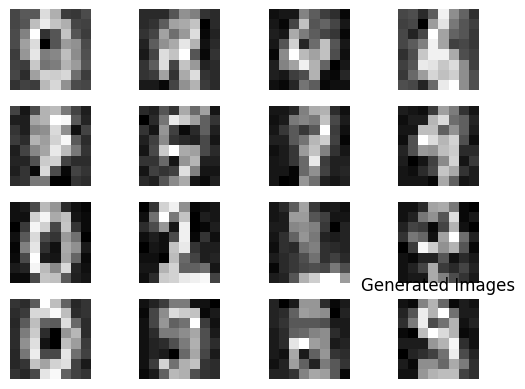

Epoch: 64, val nll=145.78706891741072
[IDF-dequant] epoch 64, val NLL = 145.7871
Epoch: 65, val nll=145.875732421875
[IDF-dequant] epoch 65, val NLL = 145.8757
Epoch: 66, val nll=146.12401646205356
[IDF-dequant] epoch 66, val NLL = 146.1240
Epoch: 67, val nll=145.47183872767857
[IDF-dequant] epoch 67, val NLL = 145.4718
Epoch: 68, val nll=145.19058175223213
[IDF-dequant] epoch 68, val NLL = 145.1906
Epoch: 69, val nll=144.72525669642857
[IDF-dequant] epoch 69, val NLL = 144.7253
saved!


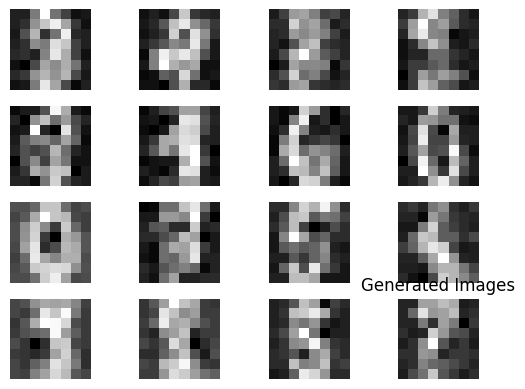

Epoch: 70, val nll=145.02797154017858
[IDF-dequant] epoch 70, val NLL = 145.0280
Epoch: 71, val nll=145.051318359375
[IDF-dequant] epoch 71, val NLL = 145.0513
Epoch: 72, val nll=144.82093610491071
[IDF-dequant] epoch 72, val NLL = 144.8209
Epoch: 73, val nll=144.71455915178572
[IDF-dequant] epoch 73, val NLL = 144.7146
saved!


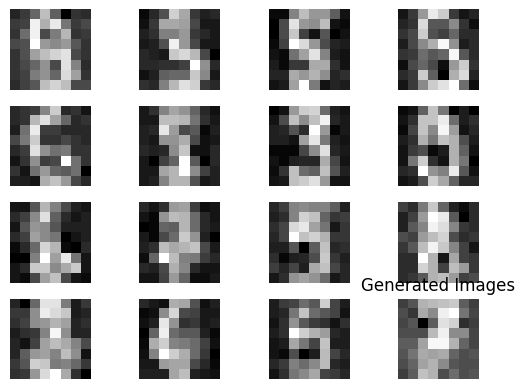

Epoch: 74, val nll=145.2825892857143
[IDF-dequant] epoch 74, val NLL = 145.2826
Epoch: 75, val nll=145.3298032924107
[IDF-dequant] epoch 75, val NLL = 145.3298
Epoch: 76, val nll=145.64512276785715
[IDF-dequant] epoch 76, val NLL = 145.6451
Epoch: 77, val nll=145.34310267857143
[IDF-dequant] epoch 77, val NLL = 145.3431
Epoch: 78, val nll=146.03234654017857
[IDF-dequant] epoch 78, val NLL = 146.0323
Epoch: 79, val nll=146.92096261160714
[IDF-dequant] epoch 79, val NLL = 146.9210
Epoch: 80, val nll=145.7237220982143
[IDF-dequant] epoch 80, val NLL = 145.7237
Epoch: 81, val nll=146.69973353794643
[IDF-dequant] epoch 81, val NLL = 146.6997
Epoch: 82, val nll=146.29418387276786
[IDF-dequant] epoch 82, val NLL = 146.2942
Epoch: 83, val nll=146.81151088169642
[IDF-dequant] epoch 83, val NLL = 146.8115
Epoch: 84, val nll=146.23304827008928
[IDF-dequant] epoch 84, val NLL = 146.2330
Epoch: 85, val nll=146.563154296875
[IDF-dequant] epoch 85, val NLL = 146.5632
Epoch: 86, val nll=146.8291922433

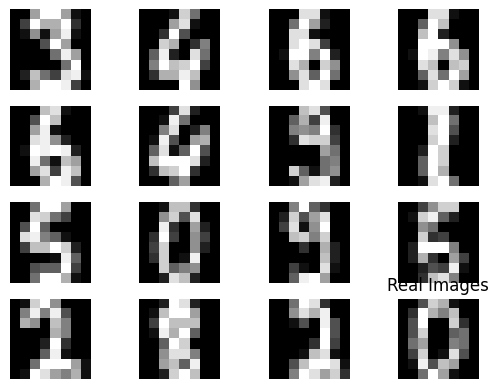

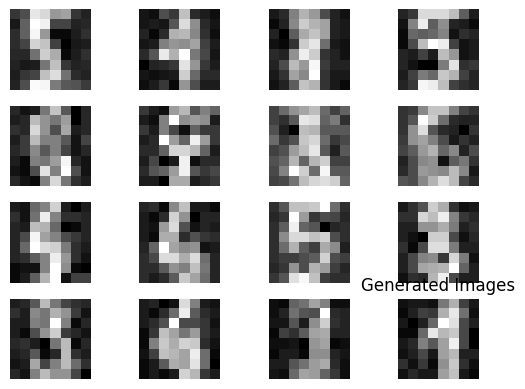

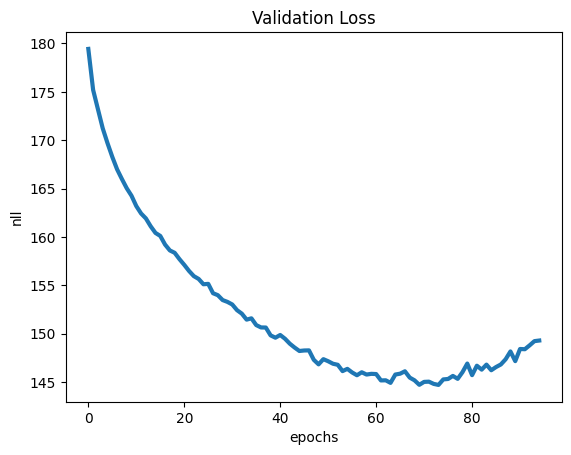

Dequantization experiment finished. Test NLL: 143.89952329767897


In [26]:
# ======================================================
# Q9 EXPERIMENT: IDF with dequantization noise (RealNVP-like behavior)
# ======================================================

import math
import torch

print("Running IDF dequantization experiment...")

# Name for this experiment (prefix for saved models/plots)
name_deq = result_dir + "idf_dequant"

# Fresh IDF model and optimizer
idf_deq = IDF(netts, num_flows, D=D)
optimizer_deq = torch.optim.Adamax(
    [p for p in idf_deq.parameters() if p.requires_grad == True],
    lr=lr
)

def training_with_dequant(name, max_patience, num_epochs, model, optimizer, training_loader, val_loader):
    """
    Same as the original IDF training loop, but with dequantization noise added
    to the inputs before feeding them to the model.
    """
    nll_val = []
    best_nll = 1e8
    patience = 0

    # Main loop
    for e in range(num_epochs):
        # Training
        model.train()
        for indx_batch, batch in enumerate(training_loader):

            # -----------------------------------------
            # Dequantization noise (similar spirit to RealNVP)
            # batch: integer-like digits; we add small random noise
            # -----------------------------------------
            noise = (1. - torch.rand(batch.shape)) / 2.0
            batch_noisy = batch + noise

            loss = model.forward(batch_noisy)

            optimizer.zero_grad()
            loss.backward(retain_graph=True)
            optimizer.step()

        # Validation (reuse the existing IDF evaluation function)
        loss_val = evaluation(val_loader, model_best=model, epoch=e)
        nll_val.append(loss_val)  # Save for plotting

        print(f"[IDF-dequant] epoch {e}, val NLL = {loss_val:.4f}")

        if e == 0:
            print('saved!')
            torch.save(model.state_dict(), name + '.model')
            best_nll = loss_val
            patience = 0
            samples_generated(name, val_loader, extra_name="_epoch_" + str(e))
        else:
            if loss_val < best_nll:
                print('saved!')
                torch.save(model.state_dict(), name + '.model')
                best_nll = loss_val
                patience = 0
                samples_generated(name, val_loader, extra_name="_epoch_" + str(e))
            else:
                patience += 1

        if patience > max_patience:
            break

    nll_val = np.asarray(nll_val)
    return nll_val


# ---- Run the experiment training loop ----
nll_val_idf_deq = training_with_dequant(
    name=name_deq,
    max_patience=max_patience,
    num_epochs=num_epochs,
    model=idf_deq,
    optimizer=optimizer_deq,
    training_loader=training_loader,
    val_loader=val_loader
)

# ---- Evaluate on the test set with the best saved model (like in the notebook) ----
test_loss_deq = evaluation(name=name_deq, test_loader=test_loader)

# Save test loss to file (same style as original)
with open(name_deq + "_test_loss.txt", "w") as f:
    f.write(str(test_loss_deq))

# ---- Visualizations: real vs generated samples + validation curve ----
samples_real(name_deq, test_loader)          # same real digits visualization
samples_generated(name_deq, test_loader)     # generated digits for dequantized IDF
plot_curve(name_deq, nll_val_idf_deq)        # validation NLL curve for this experiment

print("Dequantization experiment finished. Test NLL:", test_loss_deq)
